In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [2]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [3]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields) #0.97483 
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])

In [4]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [5]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [6]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS()) 

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric()) #galactocentric coordinates

In [7]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [8]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [9]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [10]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [11]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)

In [12]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [13]:
#Getting the Orbits of Subhalos
dt = 1*u.Myr
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]

In [14]:
#Rotating Subhalo Orbits 
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]
        rot_orbits[j][i][1] = rot_vec[1]
        rot_orbits[j][i][2] = rot_vec[2]

In [15]:
#Rotating Subhalo Velocity Orbits 
N = len(subh_orbits[0].vel.d_x)

rot_orbits_vel=np.zeros((len(ts['vx'][ind_massive]), len(subh_orbits[1].vel.d_x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec_vel = np.array([subh.vel.d_x.to(u.km/u.s)[i].value, 
                                 subh.vel.d_y.to(u.km/u.s)[i].value, 
                                 subh.vel.d_z.to(u.km/u.s)[i].value])
        rot_vec_vel = np.matmul(R, temp_vec_vel)

        rot_orbits_vel[j][i][0] = rot_vec_vel[0]
        rot_orbits_vel[j][i][1] = rot_vec_vel[1]
        rot_orbits_vel[j][i][2] = rot_vec_vel[2]

In [17]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)


In [18]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)


In [20]:
#Creating a data frame with Malhans info on Streams
data = [['Gjoll', 82.1, -13.95, 3.26, 23.58, -23.7, 78.73], 
        ['Leiptr', 89.11, -28.37, 7.39, 10.59, -9.9, 194.22],
        ['Hrid', 280.51, 33.3, 2.75, -5.88, 20.08, -238.77],
        ['Pal5', 229.65, 0.26, 20.16, -2.75, -2.68, -57.03],
        ['Gaia_1', 190.96, -9.16, 5.57, -14.39, -19.72, 214.91], #Gaia_1
        ['Ylgr', 173.82, -22.31, 9.72, -0.44, -7.65, 317.86], 
        ['Fjorm', 251.89, 65.38, 6.42, 3.92, 3.1, -25.37],
        ['Kshir', 205.88, 67.25, 9.57, -7.67, -3.92, -249.88],
        ['Gunnthra', 284.22, -73.49, 2.83, -15.83, -24.04, 132.26],
        ['Slidr', 160.05, 10.22, 2.99, -24.6, -6.65, 87.98],
        ['M92', 259.89, 43.08, 8.94, -5.15, -0.63, -140.66],
        ['NGC_3201', 152.46, -46.32, 4.99, 8.87, -2.22, 489.63],
        ['Atlas', 25.04, -29.81, 19.93, 0.04, -0.89, -85.65],
        ['C_7', 287.15, -50.17, 6.77, -13.79, -12.38, 55.05],
        ['Palca', 36.57, -36.15, 12.31, 0.9, -0.23, 106.32],
        ['Sylgr', 179.68, -2.44, 3.77, -13.98, -12.9, -184.8],
        ['Gaia_9', 233.27, 60.42, 4.68, -12.49, 6.37, -359.86],
        ['Gaia_10', 161.47, 15.17, 13.32, -4.14, -3.15, 289.62],
        ['Gaia_12', 41.05, 16.45, 15.71, 5.84, -5.66, -303.83],
        ['Indus', 340.12, -60.58, 14.96, 3.59, -4.89, -49.15],
        ['Jhelum', 351.95, -51.74, 11.39, 7.23, -4.37, -1.29],
        ['Phoenix', 23.96, -50.01, 16.8, 2.72, -0.07, 45.92],
        ['NGC5466', 214.41, 26.84, 14.09, -5.64, -0.72, 95.04],
        ['M5', 206.96, 13.5, 7.44, 3.5, -8.76, -42.97],
        ['C_20', 359.81, 8.63, 18.11, -0.58, 1.44, -116.87],
        ['C_19', 355.28, 28.82, 18.04, 1.25, -2.74, -193.48],
        ['Elqui', 19.77, -42.36, 51.41, 0.33, -0.49, 15.86],
        ['AliqaUma', 34.08, -33.97, 21.98, 0.24, -0.79, -42.33],
        ['Phlegethon', 319.89, -32.07, 3.29, -3.97, -37.66, 15.9],
        ['GD_1', 160.02, 45.9, 8.06, -6.75, -10.88, -101.83]
       ]
  
# Create the pandas DataFrame
streams = pd.DataFrame(data, columns=['Stream', 'ra', 'dec', 'distance', 'pm_ra_cosdec', 'pm_dec', 'radial_velocity'])
  

# print dataframe.
streams

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  radial_velocity
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70            78.73
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90           194.22
2         Hrid  280.51  33.30      2.75         -5.88   20.08          -238.77
3         Pal5  229.65   0.26     20.16         -2.75   -2.68           -57.03
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72           214.91
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65           317.86
6        Fjorm  251.89  65.38      6.42          3.92    3.10           -25.37
7        Kshir  205.88  67.25      9.57         -7.67   -3.92          -249.88
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04           132.26
9        Slidr  160.05  10.22      2.99        -24.60   -6.65            87.98
10         M92  259.89  43.08      8.94         -5.15   -0.63          -140.66
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22           489.63
12       Atlas   25.04 -29.81     19.93          0.04   -0.89           -85.65
13         C_7  287.15 -50.17      6.77        -13.79  -12.38            55.05
14       Palca   36.57 -36.15     12.31          0.90   -0.23           106.32
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90          -184.80
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37          -359.86
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15           289.62
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66          -303.83
19       Indus  340.12 -60.58     14.96          3.59   -4.89           -49.15
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37            -1.29
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07            45.92
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72            95.04
23          M5  206.96  13.50      7.44          3.50   -8.76           -42.97
24        C_20  359.81   8.63     18.11         -0.58    1.44          -116.87
25        C_19  355.28  28.82     18.04          1.25   -2.74          -193.48
26       Elqui   19.77 -42.36     51.41          0.33   -0.49            15.86
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79           -42.33
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66            15.90
29        GD_1  160.02  45.90      8.06         -6.75  -10.88          -101.83

In [25]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDist(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
        #Going back for 3 Gyrs (3000 steps of -1Myr)
        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            
            #For time
            time_occurance = -dt*np.argmin(rel_dist)
            
            #For velocity 
            ind_time = np.argmin(rel_dist)
            vel_x = orbit_long.vel.d_x.to(u.km/u.s) - rot_orbits_vel[subh,:,0]*(u.km/u.s) 
            vel_y = orbit_long.vel.d_y.to(u.km/u.s) - rot_orbits_vel[subh,:,1]*(u.km/u.s)
            vel_z = orbit_long.vel.d_z.to(u.km/u.s) - rot_orbits_vel[subh,:,2]*(u.km/u.s)
            rel_vel = np.sqrt((vel_x**2) + (vel_y**2) + (vel_z**2))
            
            data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
            data_temp['Subhalo_'+ str(subh)+ ' Time (Myr)'] = [time_occurance.value]
            data_temp['Subhalo_'+ str(subh)+ ' Relative Velocity (km/s)'] = [rel_vel[ind_time].value]
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1




In [30]:
pb = ClosestDist(streams)
pb

Stream  Subhalo_0 Distance (kpc)  Subhalo_0 Time (Myr)  \
0        Gjoll                 23.418654                -287.0   
1       Leiptr                  8.075946                -329.0   
2         Hrid                 54.796486                -325.0   
3         Pal5                 33.962001                -223.0   
4       Gaia_1                 30.611827                -405.0   
5         Ylgr                 31.574246                -281.0   
6        Fjorm                 58.666359                -189.0   
7        Kshir                 41.470491                -244.0   
8     Gunnthra                 38.755451                -293.0   
9        Slidr                 41.036184                -301.0   
10         M92                 34.570465                -306.0   
11    NGC_3201                 11.796747                -307.0   
12       Atlas                 35.003437                -160.0   
13         C_7                 16.504717                -297.0   
14       Palca                 35.056198                -327.0   
15       Sylgr                 53.156212                -345.0   
16      Gaia_9                 47.914782                -286.0   
17     Gaia_10                 34.506814                -259.0   
18     Gaia_12                 49.108634                -413.0   
19       Indus                 49.354602                -296.0   
20      Jhelum                 53.039738                -326.0   
21     Phoenix                 41.578833                -331.0   
22     NGC5466                 23.328708                -220.0   
23          M5                 43.031747                -294.0   
24        C_20                 29.714292                -150.0   
25        C_19                 52.765472                -250.0   
26       Elqui                  9.720509                -158.0   
27    AliqaUma                 37.295617                -155.0   
28  Phlegethon                 37.451702                -304.0   
29        GD_1                 43.480403                -280.0   

    Subhalo_0 Relative Velocity (km/s)  Subhalo_1 Distance (kpc)  \
0                           535.449884                 88.090466   
1                           443.922337                 97.549989   
2                           435.146645                 97.453298   
3                           561.342650                107.766900   
4                           441.321231                 81.579544   
5                           636.041846                102.736961   
6                           461.360785                 94.740331   
7                           632.240152                102.753624   
8                           408.741276                110.538472   
9                           511.147252                103.437170   
10                          467.103347                108.097168   
11                          471.419281                 89.068789   
12                          445.319680                 98.618591   
13                          487.090181                 98.088000   
14                          574.605860                104.262870   
15                          605.733687                 89.813475   
16                          567.750865                102.663708   
17                          475.927630                 91.476524   
18                          296.656025                 56.779702   
19                          629.360092                100.078397   
20                          637.653561                 93.268970   
21                          564.091712                102.283769   
22                          473.308118                 89.237142   
23                          523.177096                 91.393205   
24                          600.069524                 87.532404   
25                          593.613418                 98.008463   
26                          425.962978                 78.170147   
27                          429.071979                 98

In [31]:
pb.to_csv('Closest_Distance_Subhalo_to_All_Streams.csv', index='False')

In [19]:
#pb = pd.read_csv('Closest_Distance_Subhalo_to_All_Streams.csv')
#pb = pb.drop("Unnamed: 0",axis=1)

In [17]:
pb

Stream  Subhalo_0 Distance (kpc)  Subhalo_0 Time (Myr)  \
0        Gjoll                 23.418654                -287.0   
1       Leiptr                  8.075946                -329.0   
2         Hrid                 54.796486                -325.0   
3         Pal5                 33.962001                -223.0   
4       Gaia_1                 30.611827                -405.0   
5         Ylgr                 31.574246                -281.0   
6        Fjorm                 58.666359                -189.0   
7        Kshir                 41.470491                -244.0   
8     Gunnthra                 38.755451                -293.0   
9        Slidr                 41.036184                -301.0   
10         M92                 34.570465                -306.0   
11    NGC_3201                 11.796747                -307.0   
12       Atlas                 35.003437                -160.0   
13         C_7                 16.504717                -297.0   
14       Palca                 35.056198                -327.0   
15       Sylgr                 53.156212                -345.0   
16      Gaia_9                 47.914782                -286.0   
17     Gaia_10                 34.506814                -259.0   
18     Gaia_12                 49.108634                -413.0   
19       Indus                 49.354602                -296.0   
20      Jhelum                 53.039738                -326.0   
21     Phoenix                 41.578833                -331.0   
22     NGC5466                 23.328708                -220.0   
23          M5                 43.031747                -294.0   
24        C_20                 29.714292                -150.0   
25        C_19                 52.765472                -250.0   
26       Elqui                  9.720509                -158.0   
27    AliqaUma                 37.295617                -155.0   
28  Phlegethon                 37.451702                -304.0   
29        GD_1                 43.480403                -280.0   

    Subhalo_0 Relative Velocity (km/s)  Subhalo_1 Distance (kpc)  \
0                           535.449884                 88.090466   
1                           443.922337                 97.549989   
2                           435.146645                 97.453298   
3                           561.342650                107.766900   
4                           441.321231                 81.579544   
5                           636.041846                102.736961   
6                           461.360785                 94.740331   
7                           632.240152                102.753624   
8                           408.741276                110.538472   
9                           511.147252                103.437170   
10                          467.103347                108.097168   
11                          471.419281                 89.068789   
12                          445.319680                 98.618591   
13                          487.090181                 98.088000   
14                          574.605860                104.262870   
15                          605.733687                 89.813475   
16                          567.750865                102.663708   
17                          475.927630                 91.476524   
18                          296.656025                 56.779702   
19                          629.360092                100.078397   
20                          637.653561                 93.268970   
21                          564.091712                102.283769   
22                          473.308118                 89.237142   
23                          523.177096                 91.393205   
24                          600.069524                 87.532404   
25                          593.613418                 98.008463   
26                          425.962978                 78.170147   
27                          429.071979                 98

<ipython-input-26-0f070135b95a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


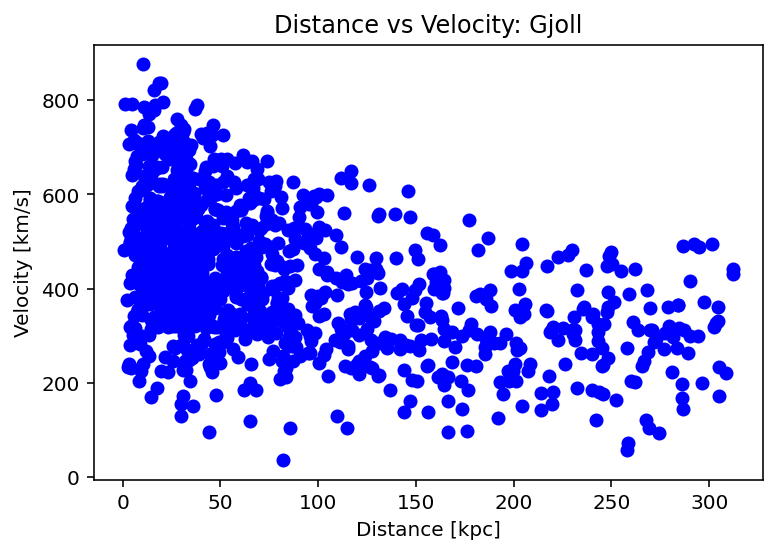

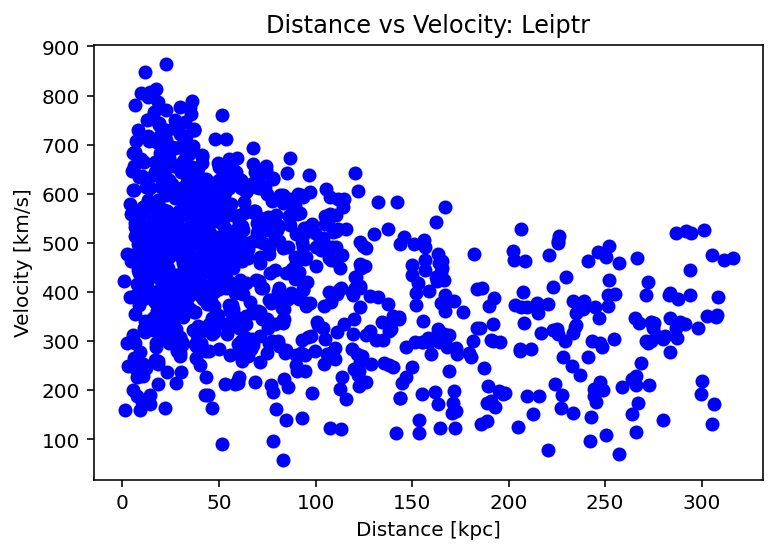

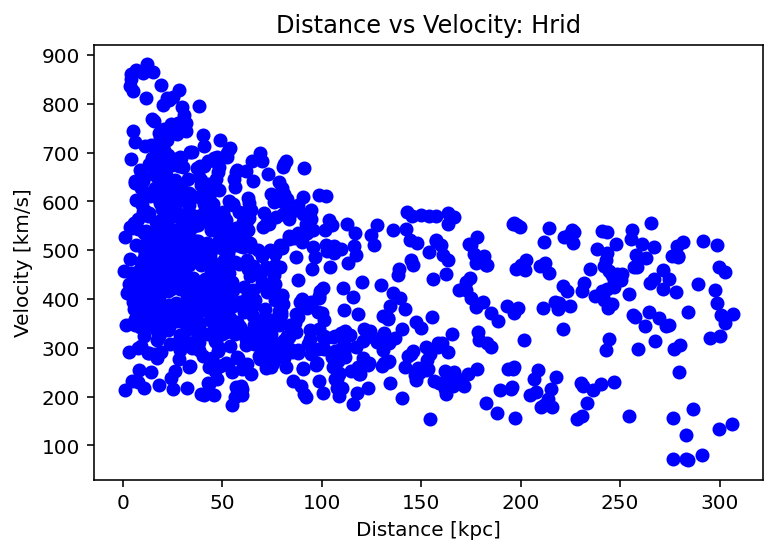

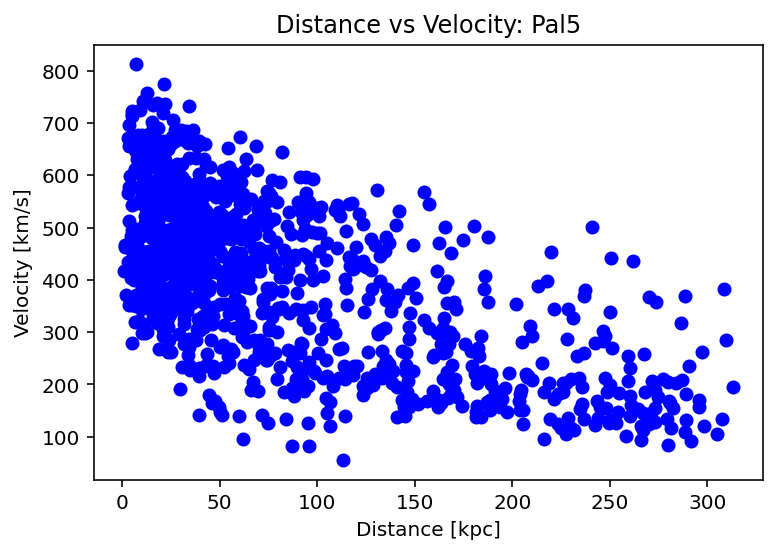

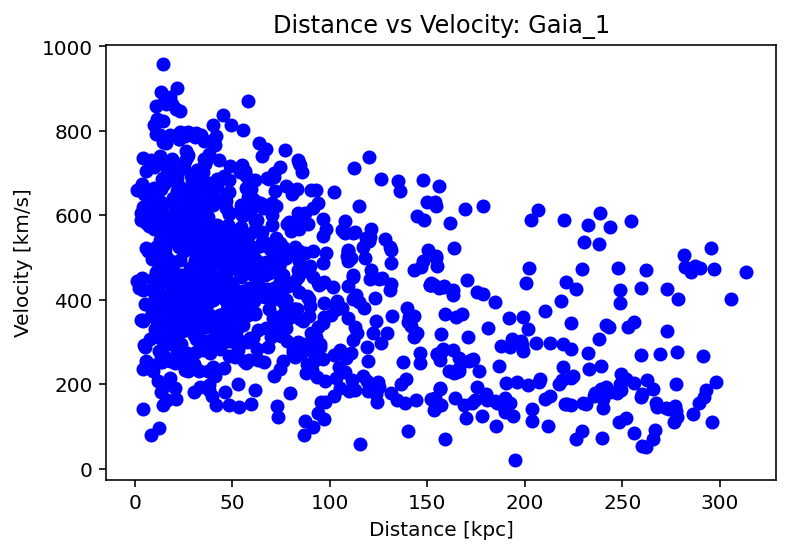

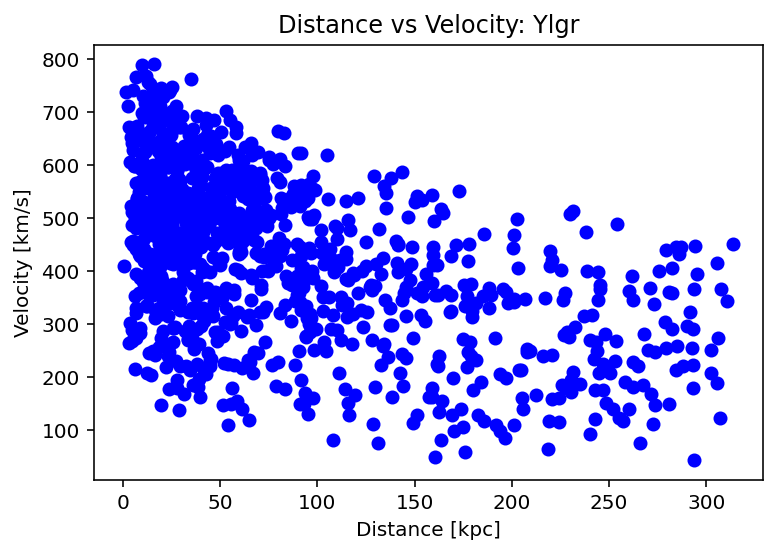

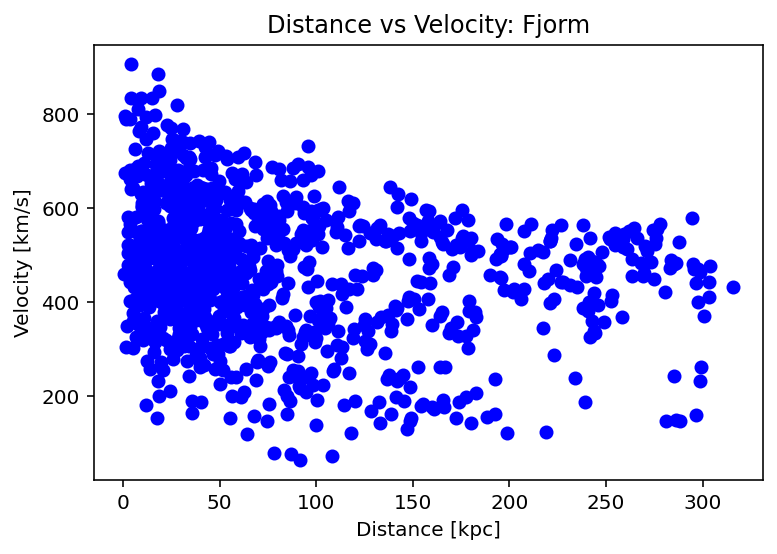

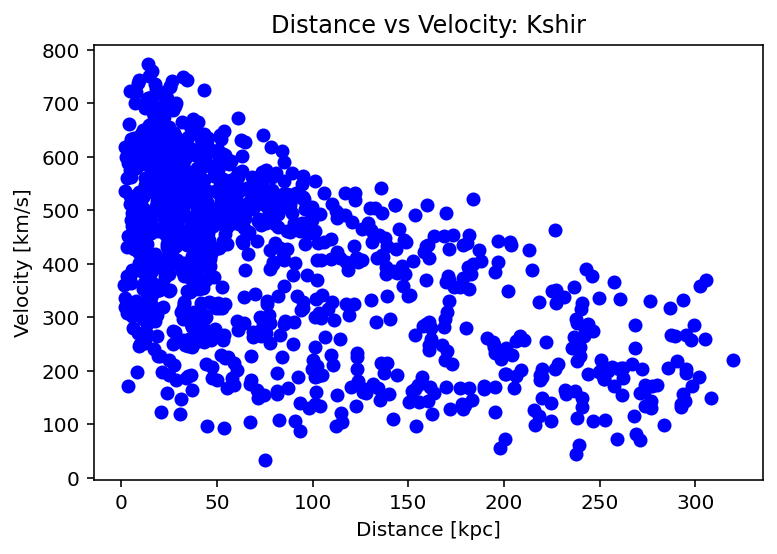

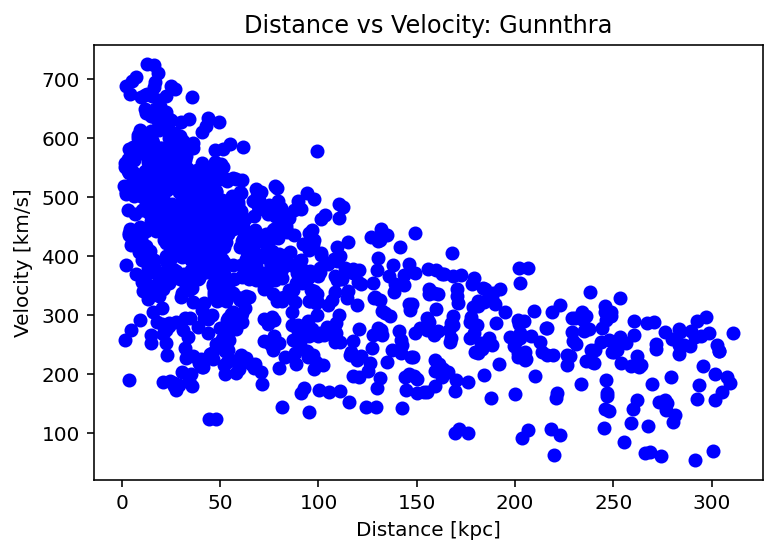

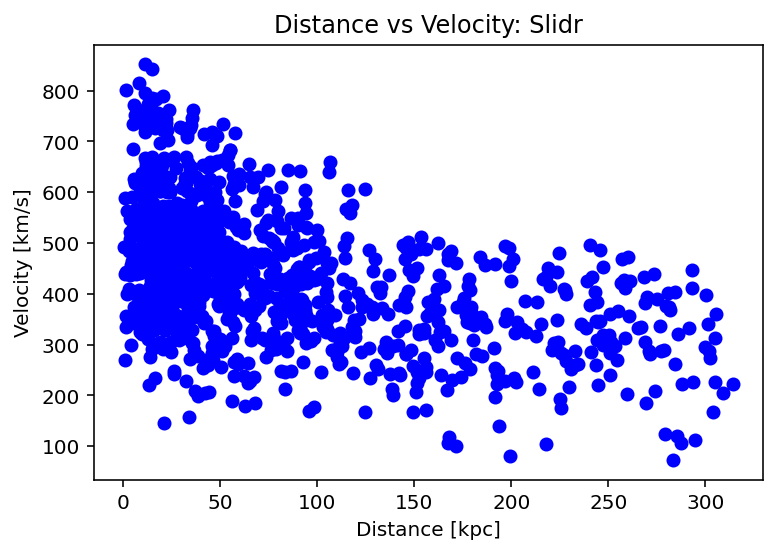

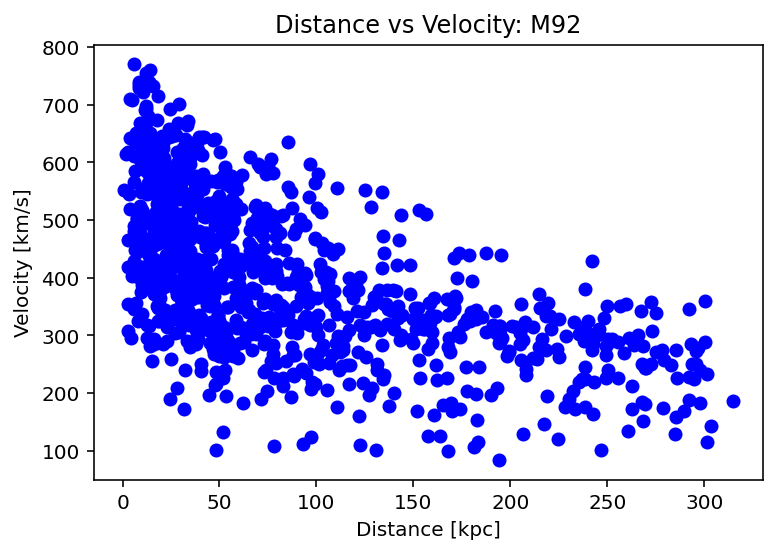

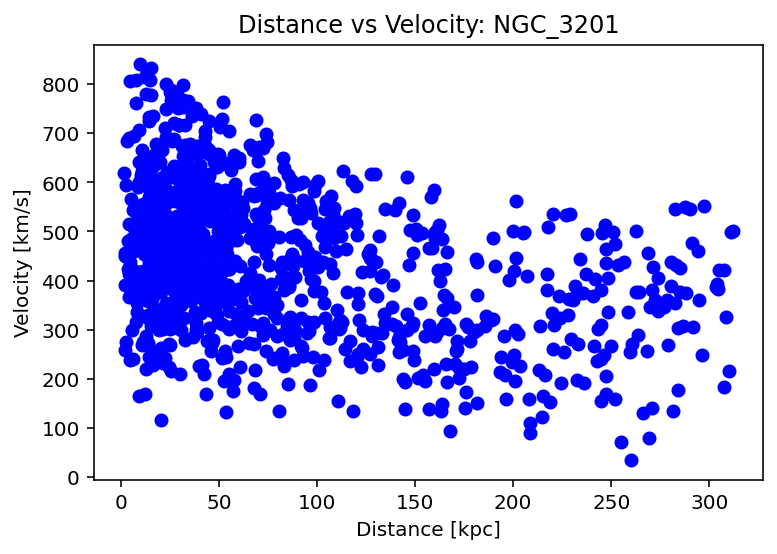

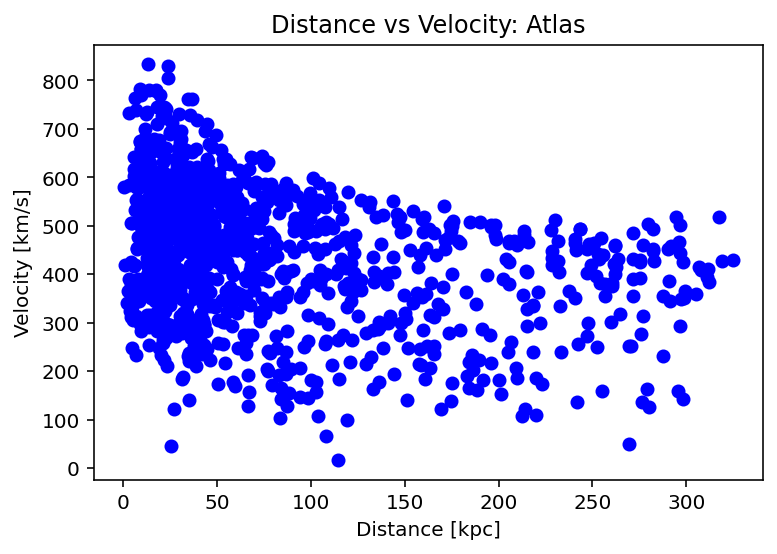

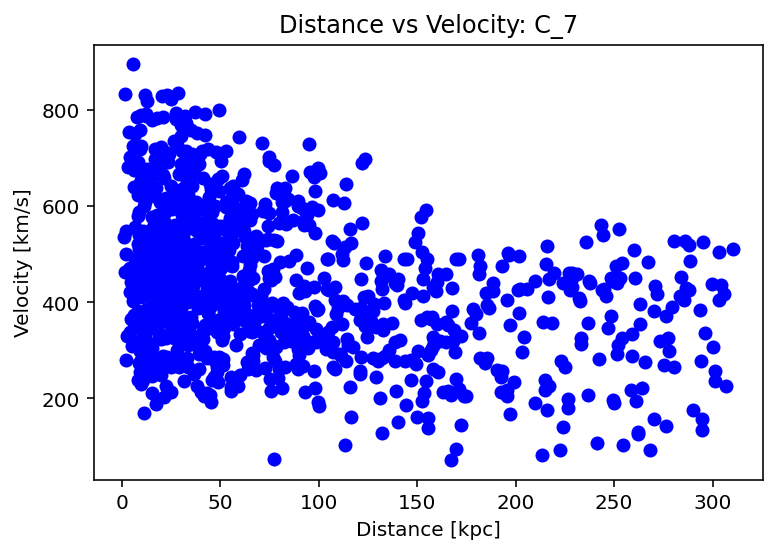

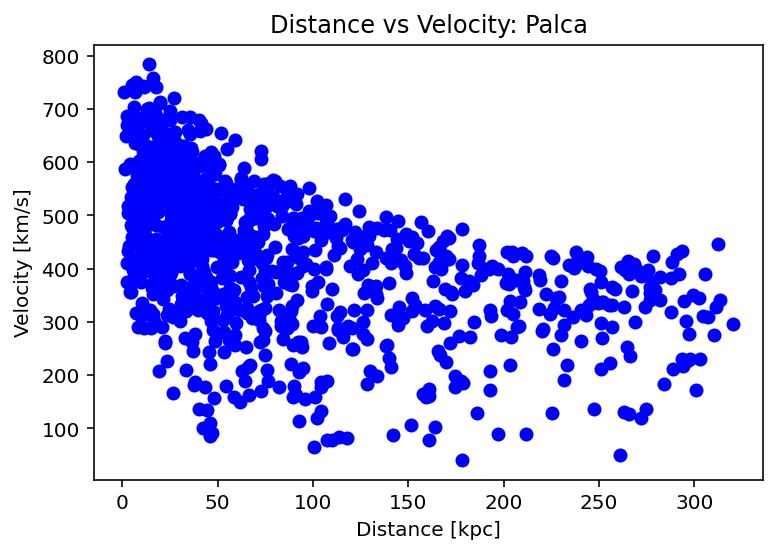

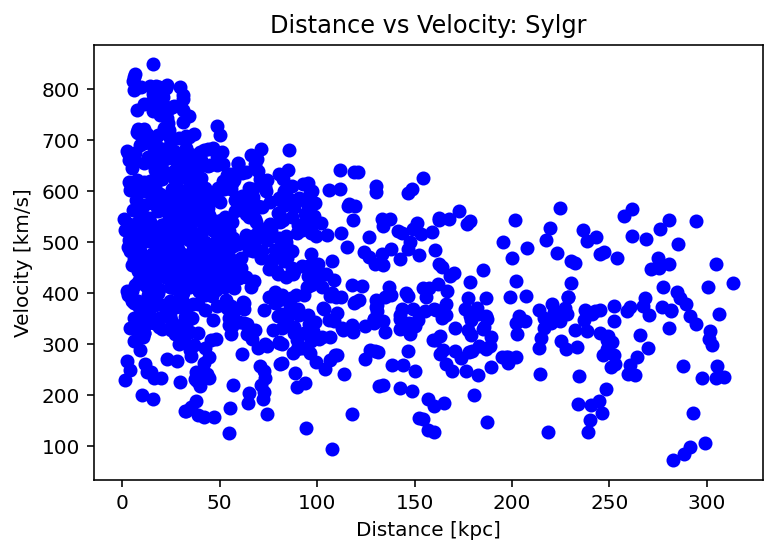

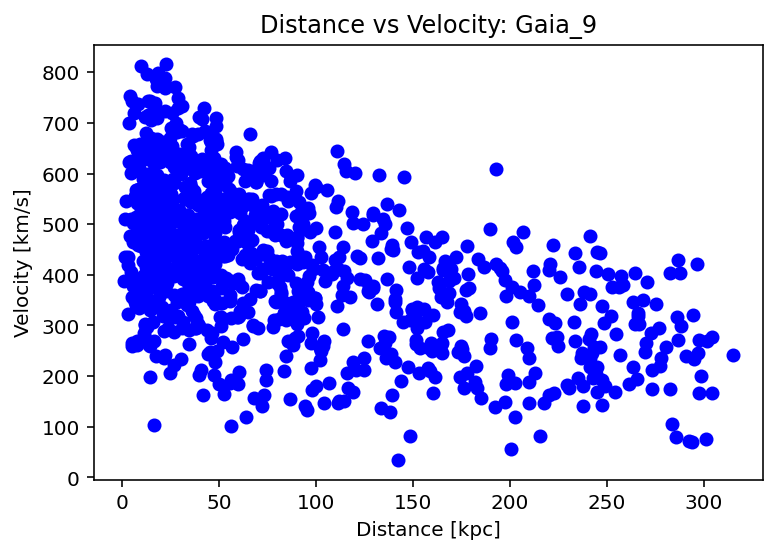

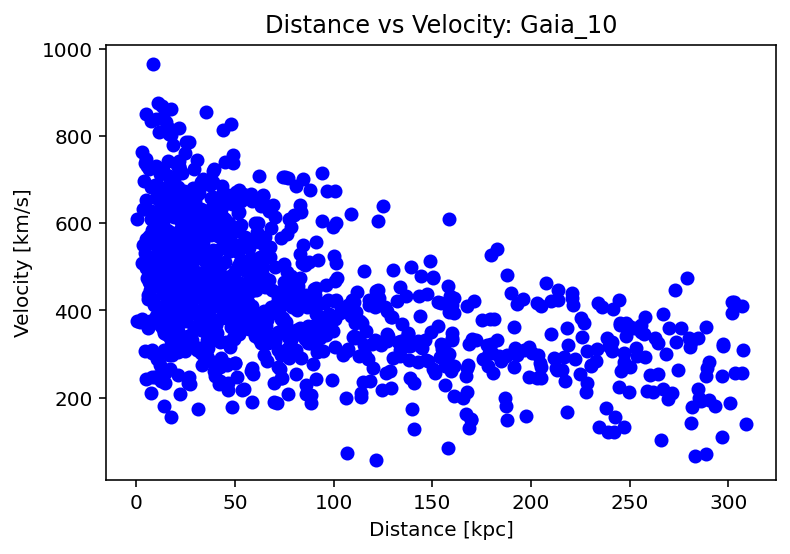

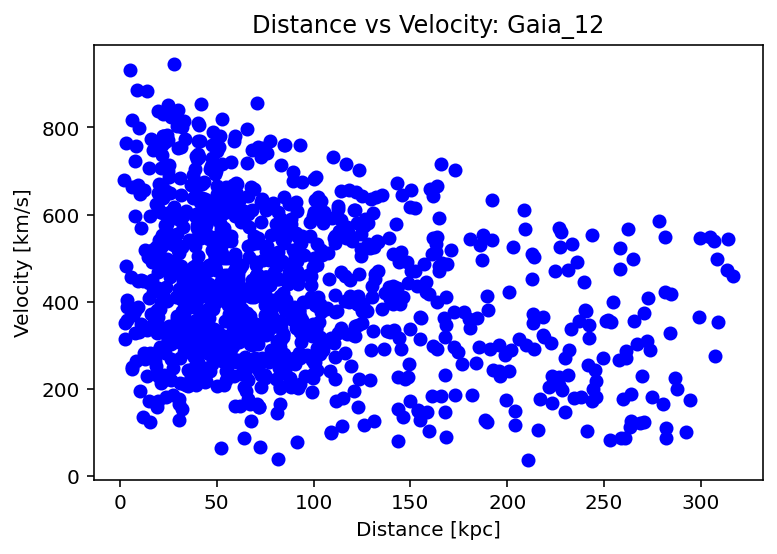

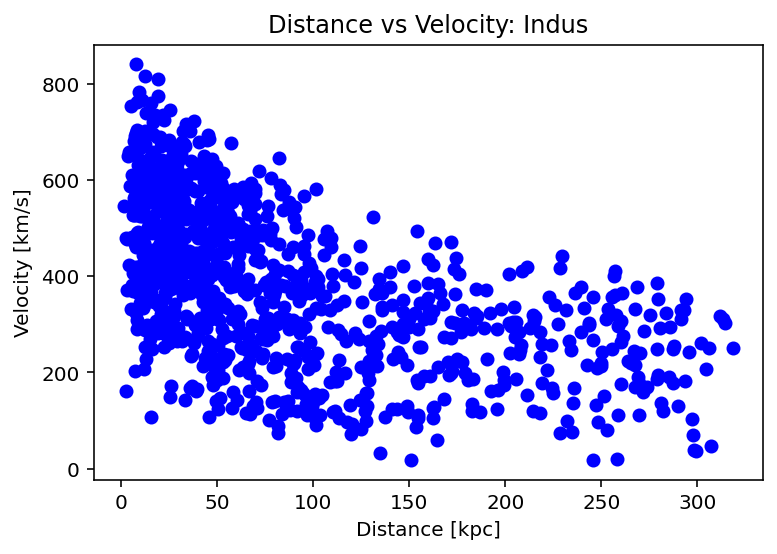

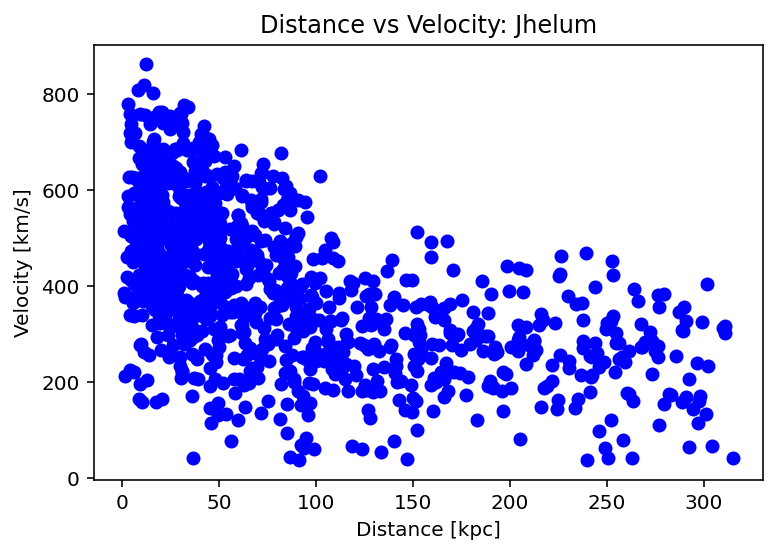

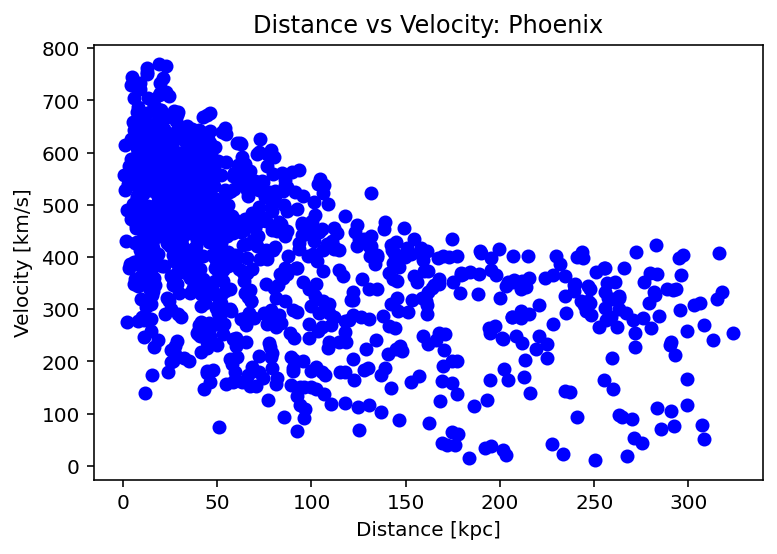

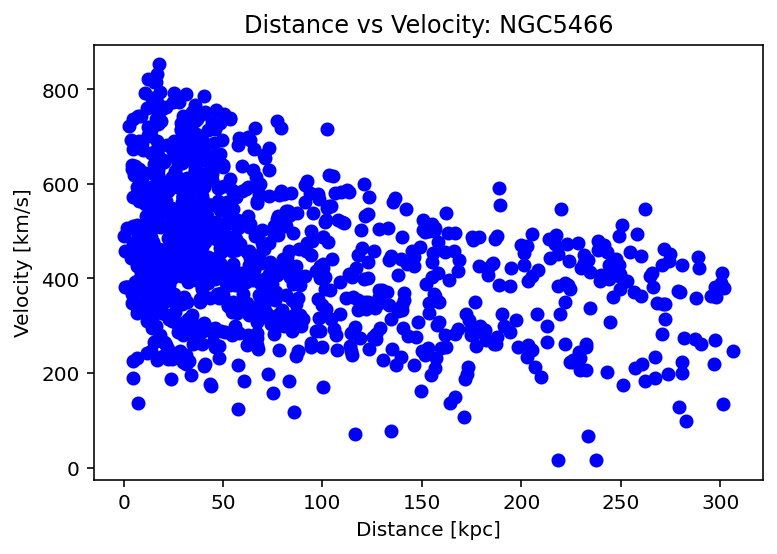

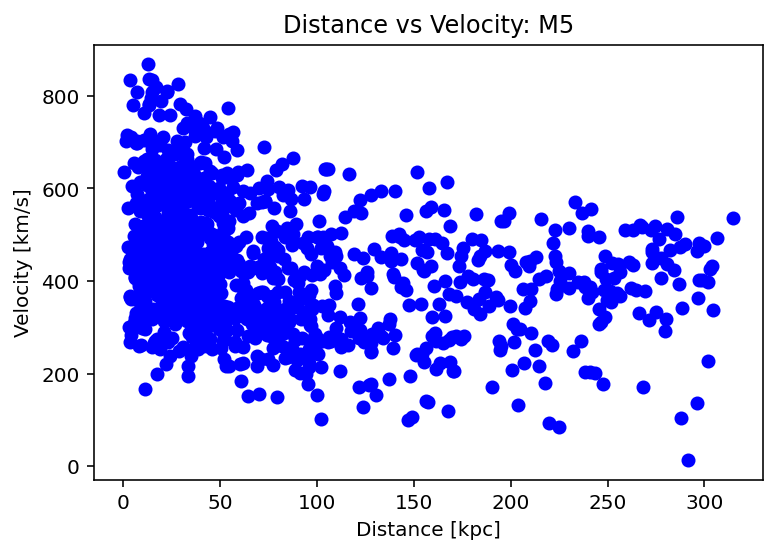

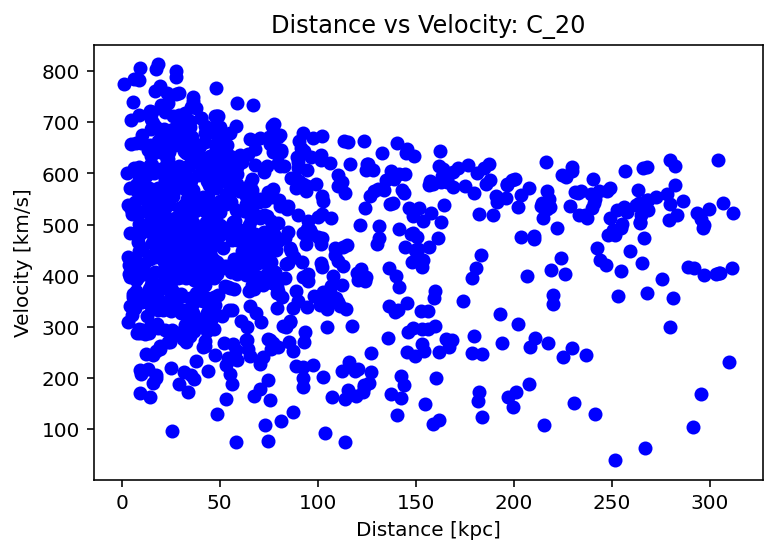

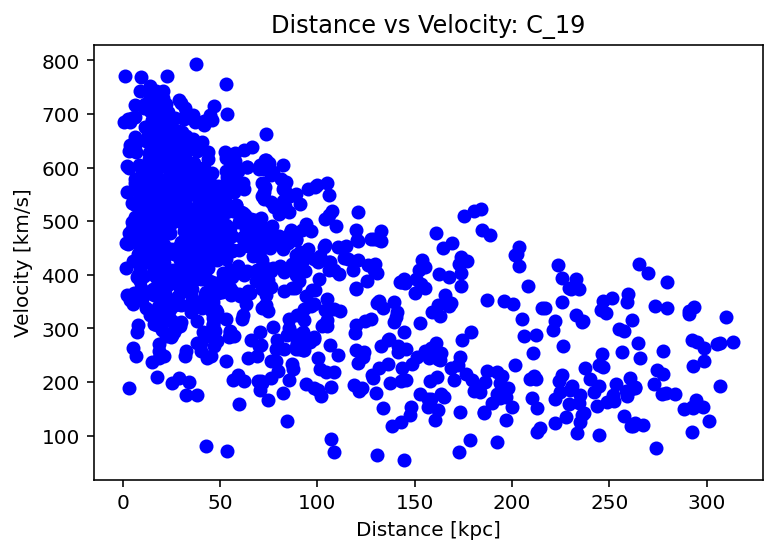

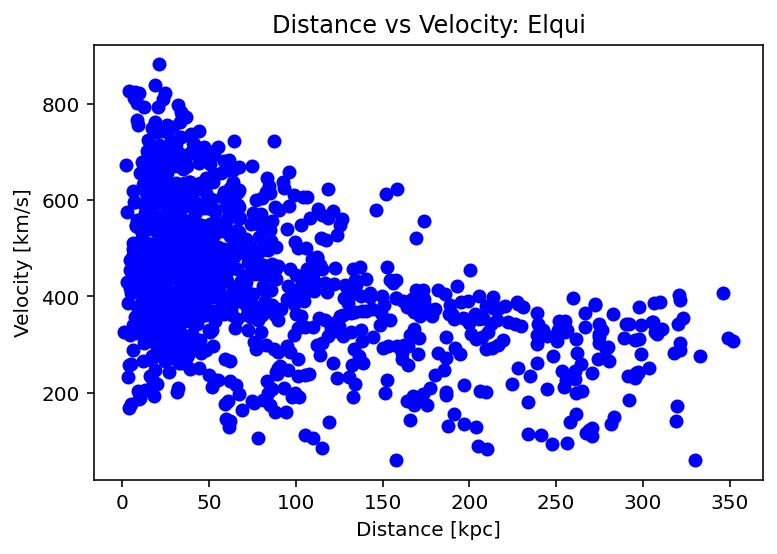

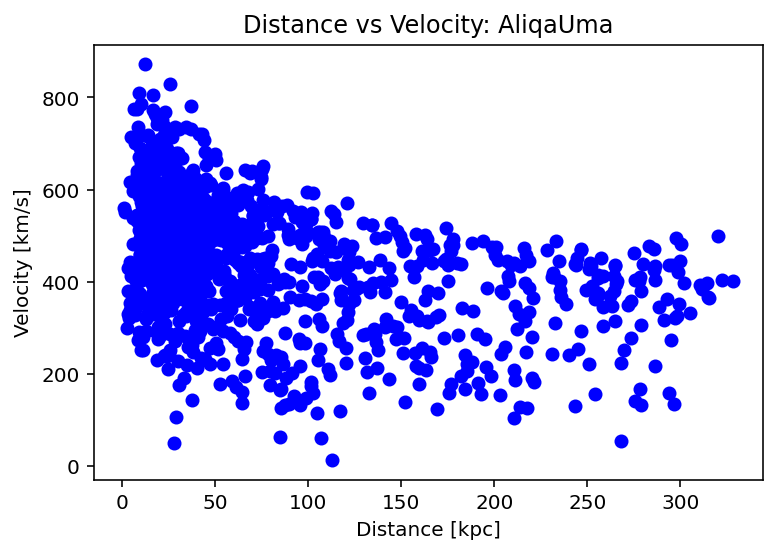

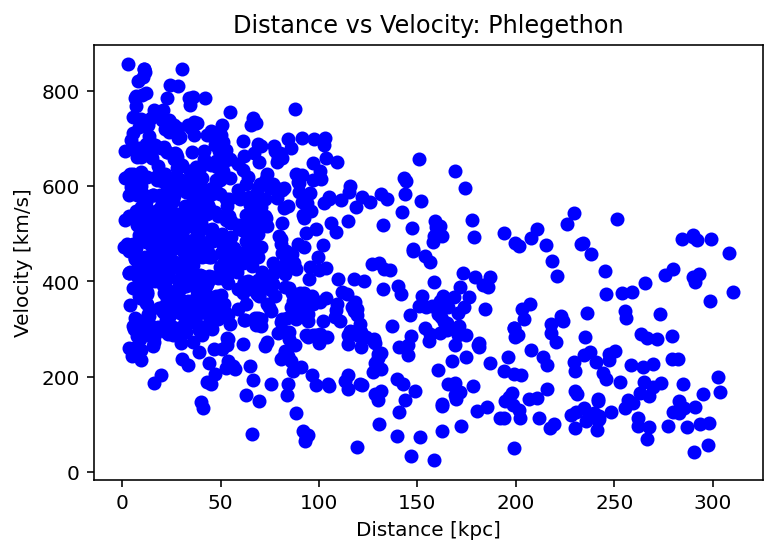

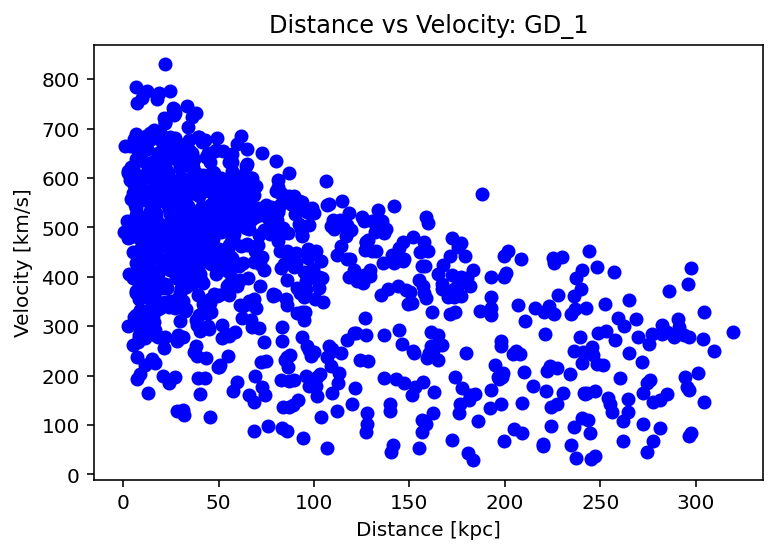

In [26]:
#Creating Visualization of Subhalo impact on streams (distance vs velocity kick)
for i in range(len(pb)):
    plt.figure()
    for subh in range(len(trot)):
        plt.scatter(pb['Subhalo_'+str(subh)+' Distance (kpc)'][i],pb['Subhalo_'+str(subh)+' Relative Velocity (km/s)'][i], color='blue') 
    plt.xlabel('Distance [kpc]')
    plt.ylabel('Velocity [km/s]')
    plt.title('Distance vs Velocity: '+str(pb.iloc[i][0]))
    #plt.legend(loc='best')
    plt.savefig('Distance_vs_Velocity/'+str(pb.iloc[i][0])+'.png', transparent=False, dpi=200)
    

In [30]:
#Calculation of Velocity Kick
#This is for GJOLL (UNITS ARE WRONG, check below for correct units)

G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
r_min = np.array(pb_new.iloc[0][1:])*u.kpc  #smallest distance between subhalos and stream 
v_rel = np.array(pb.iloc[0][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos

delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
vel_kick = np.sqrt(np.sum(delta_v**2))
vel_kick 


<Quantity 0.00132343 m3 solMass / (kg km kpc s)>

In [106]:
#Creating a pd to store the delta values from each subhalo 
lst_names = []
for i in range(len(pb['Stream'])):
    lst_names = np.append(lst_names, (pb['Stream'][i]))
    data = {'Streams': lst_names}
delta_v_general_info = pd.DataFrame(data = data)
delta_v_general_info['Streams'][0]

lst_col_name = np.array(['Streams'])
for i in range(len(ts[ind_massive]['mvir'])):
    lst_col_name = np.append(lst_col_name, 'Subhalo_'+str(i))  
lst_col_name
col = [lst_col_name]
delta_v_general_info.assign(columns = col)

'Gjoll'

In [75]:
#GOALS FOR VEL_KICK: 
#distribution for each individual kicks 
#Take one stream and plot the distribution of all the velocity kicks 

Gjoll 82.79757702976359 km / s
Leiptr 289.59960777892377 km / s
Hrid 43.54216601894275 km / s
Pal5 54.459928858211654 km / s
Gaia_1 76.8518456730914 km / s
Ylgr 51.698709045897765 km / s
Fjorm 38.35911356424143 km / s
Kshir 39.59835389135381 km / s
Gunnthra 65.5416071070367 km / s
Slidr 49.497741113577625 km / s
M92 64.29544057068843 km / s
NGC_3201 186.69332471642355 km / s
Atlas 66.60637509414883 km / s
C_7 129.14598597769947 km / s
Palca 51.54226650765606 km / s
Sylgr 32.24501817227468 km / s
Gaia_9 38.165508764019016 km / s
Gaia_10 63.2197237110307 km / s
Gaia_12 71.26681592146299 km / s
Indus 33.42500842191759 km / s
Jhelum 30.698151143220016 km / s


<ipython-input-23-e4707a04966e>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Phoenix 44.26661973383291 km / s
NGC5466 94.02941504167315 km / s
M5 46.11696122136816 km / s
C_20 58.22793981155212 km / s
C_19 33.14704681420302 km / s
Elqui 250.7480229848976 km / s
AliqaUma 64.87993926230233 km / s
Phlegethon 43.34778802599269 km / s
GD_1 37.135770763864734 km / s


<Quantity [0.00132343, 0.00450406, 0.00074559, 0.00088693, 0.00123317,
           0.00083843, 0.00072152, 0.00068164, 0.00105433, 0.000805  ,
           0.00104377, 0.00291312, 0.00106941, 0.00204541, 0.00086624,
           0.00059528, 0.00064274, 0.00102455, 0.00117104, 0.00089529,
           0.00069725, 0.00081147, 0.00150329, 0.00084045, 0.00101036,
           0.00108008, 0.0039239 , 0.00104329, 0.00074338, 0.00062435] m3 solMass / (kg km kpc s)>

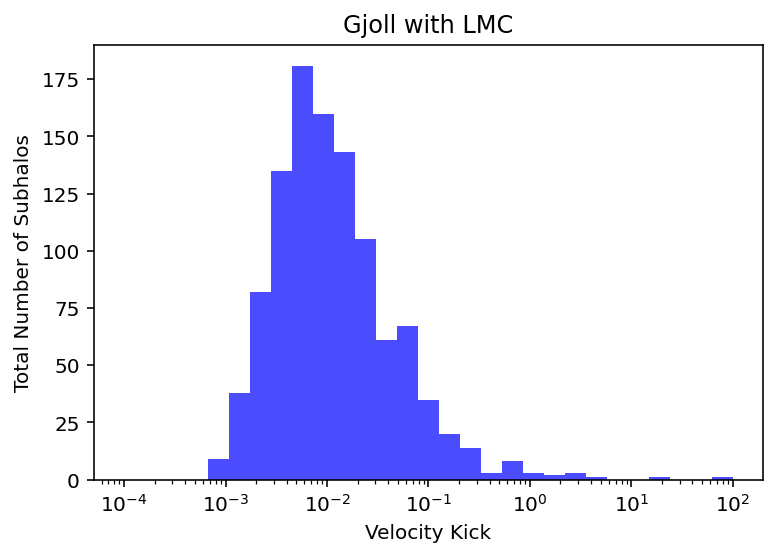

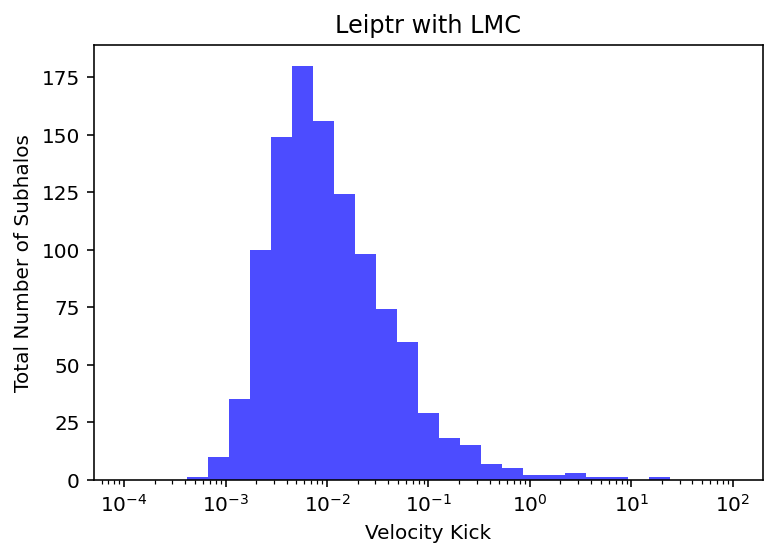

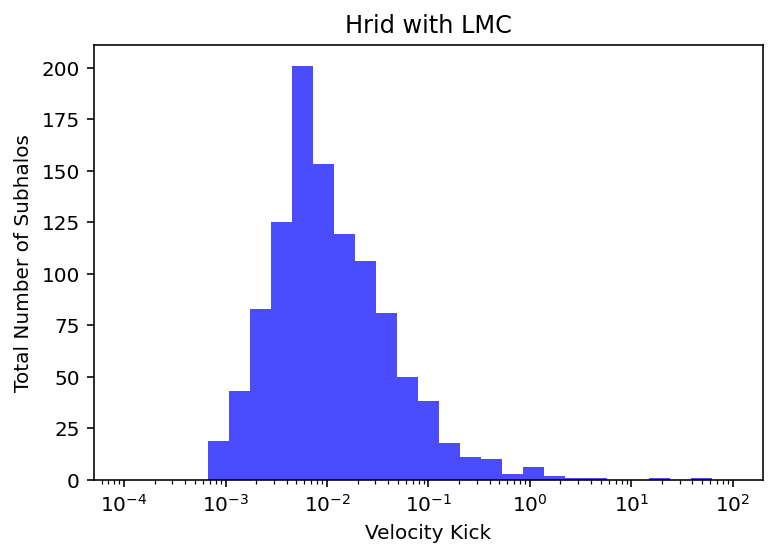

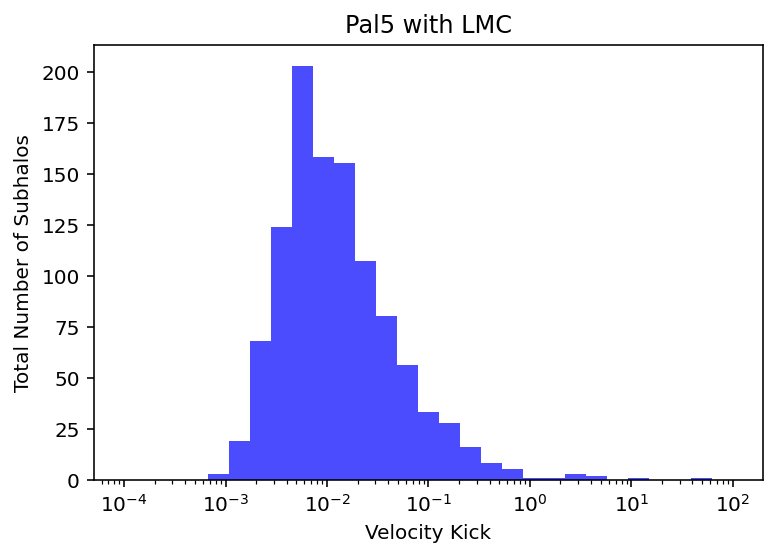

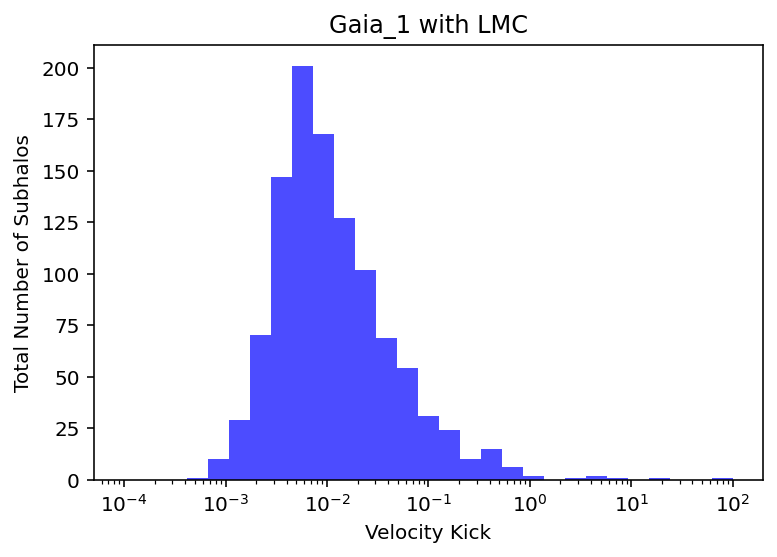

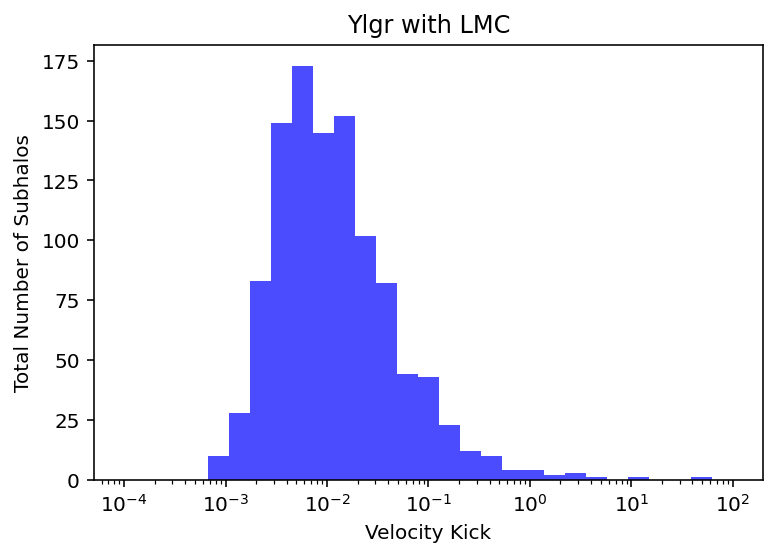

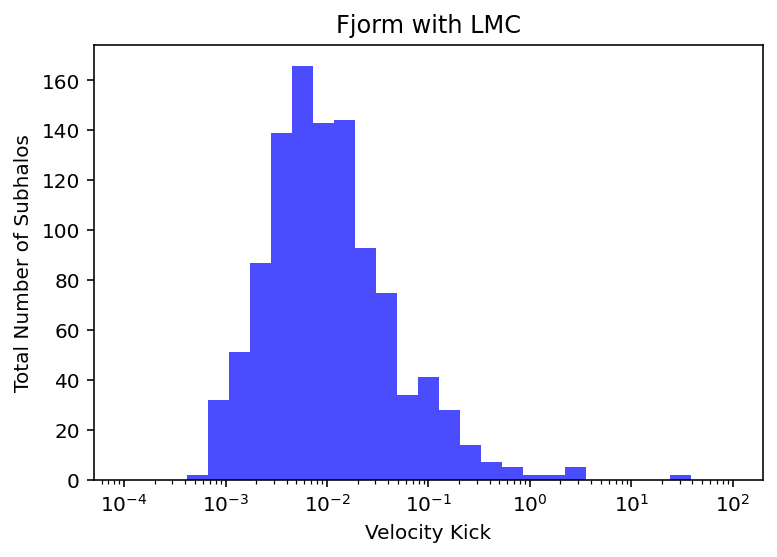

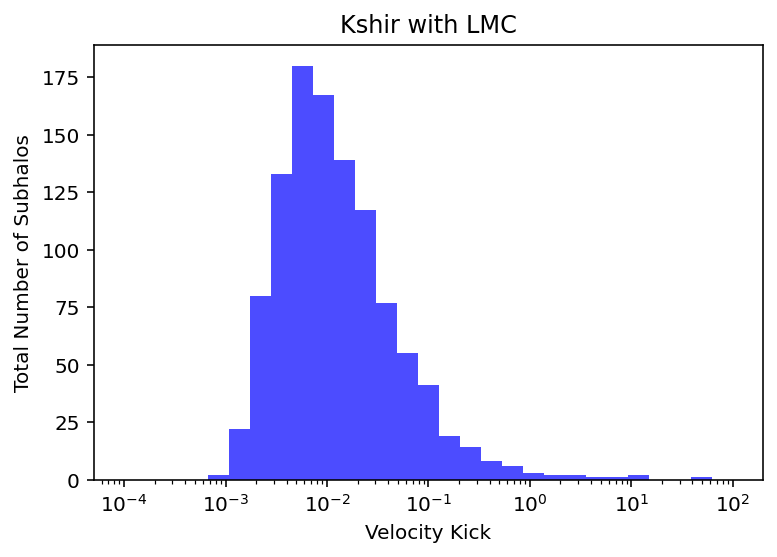

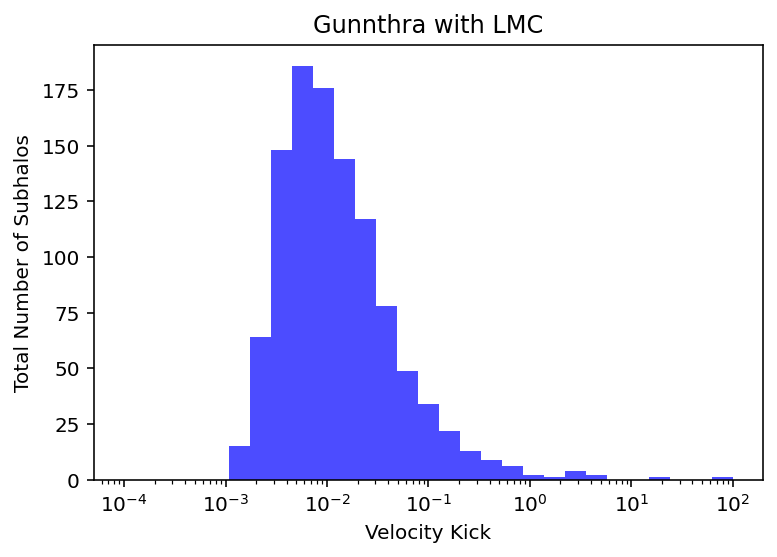

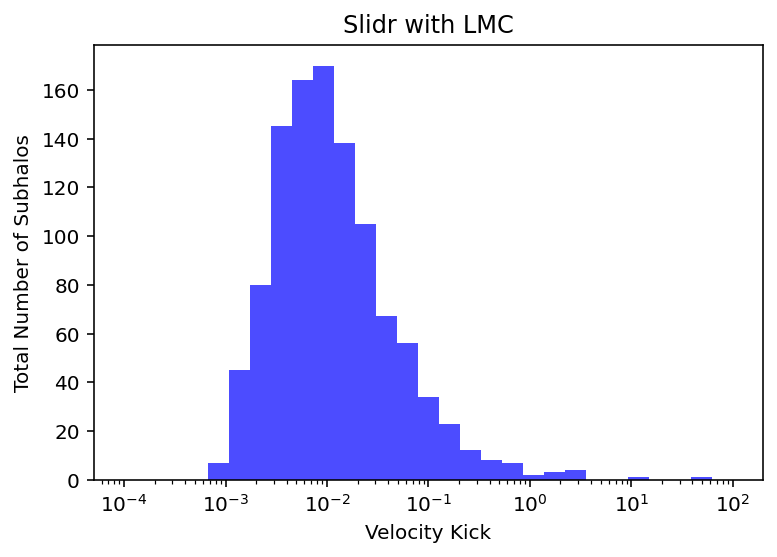

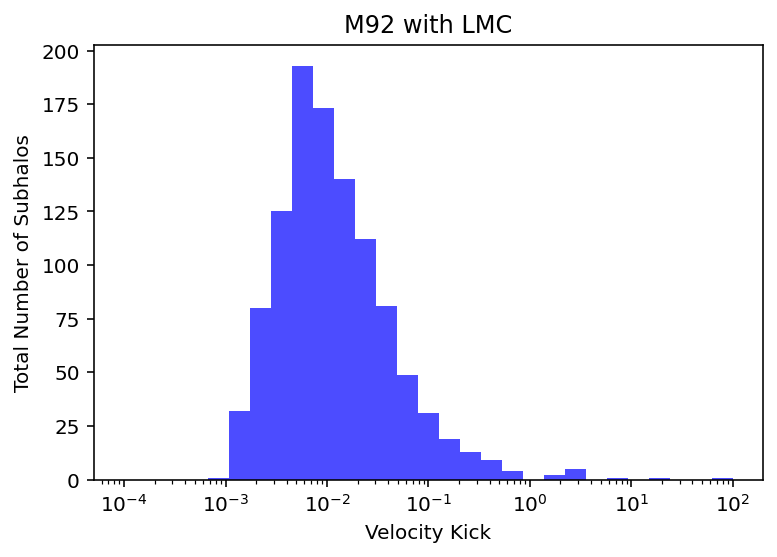

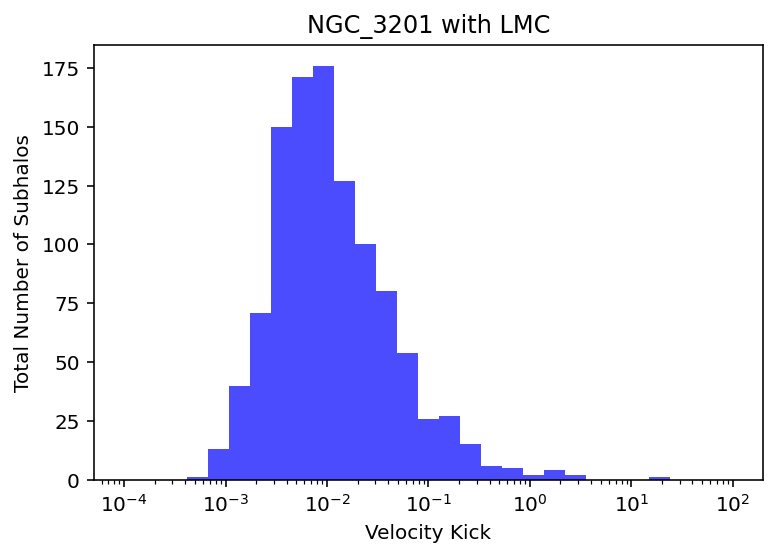

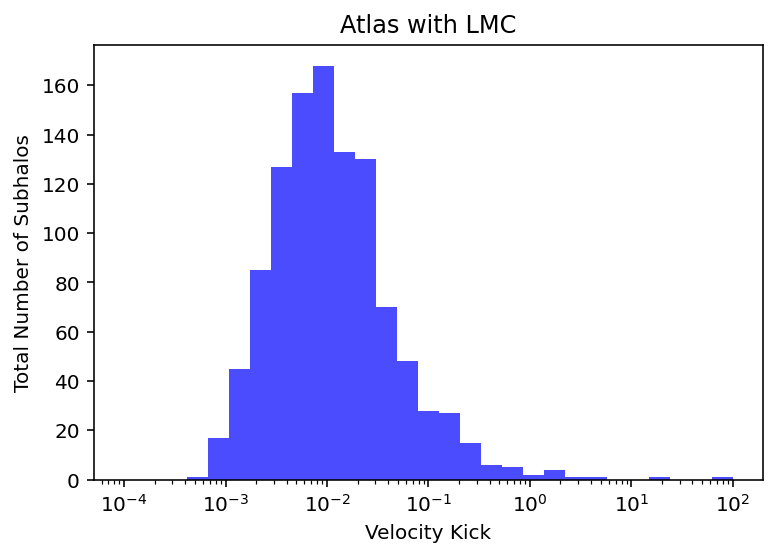

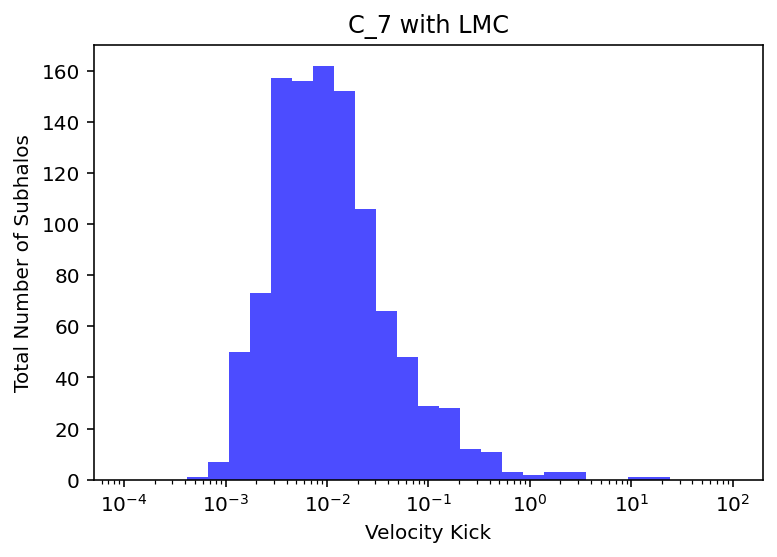

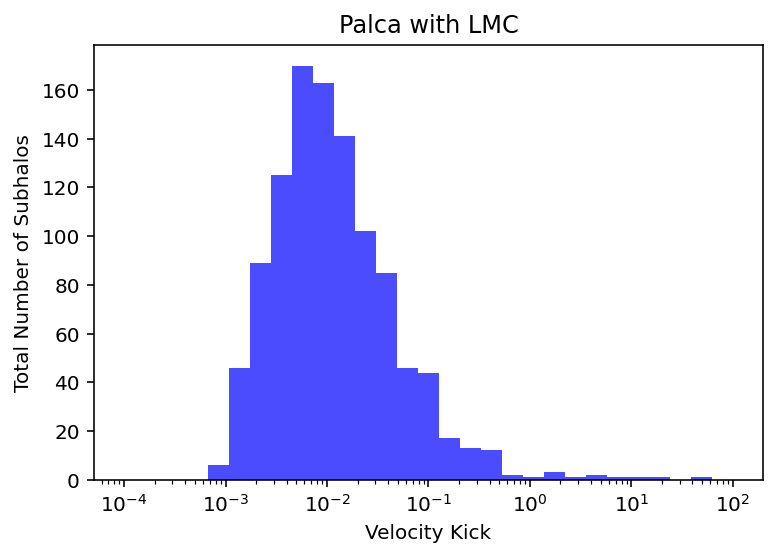

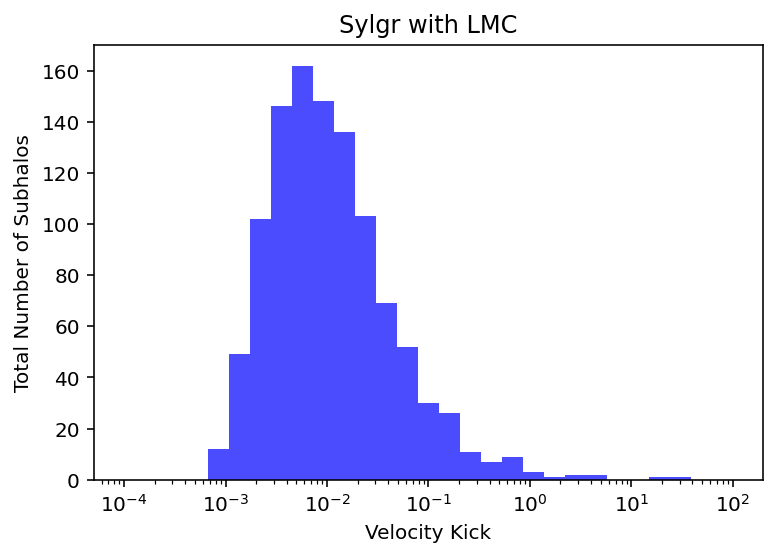

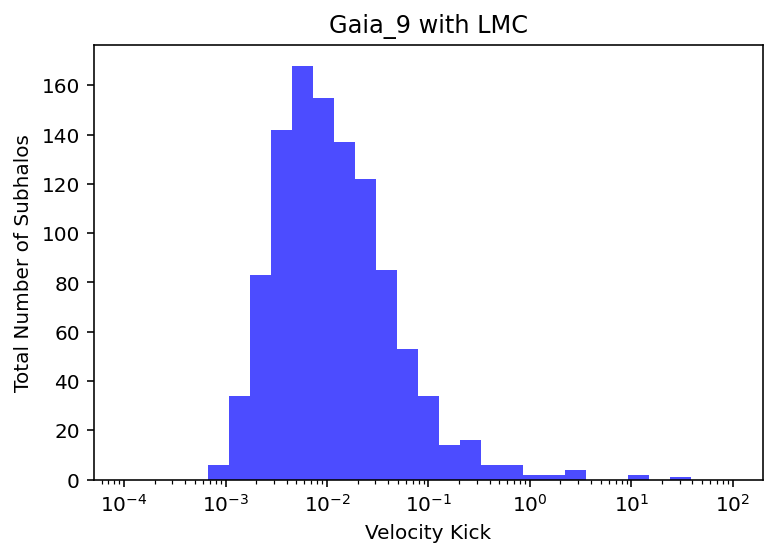

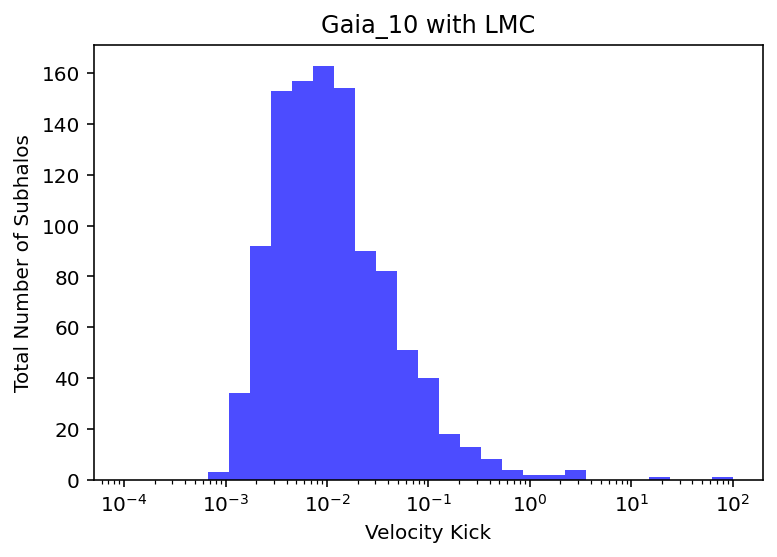

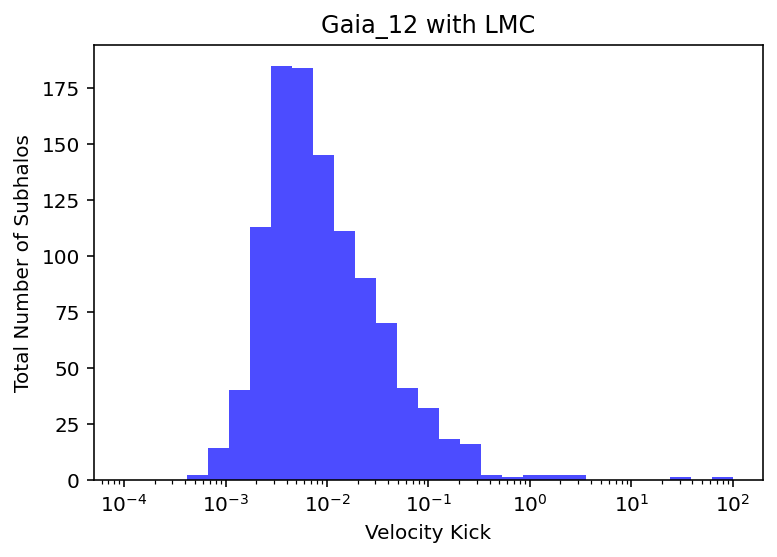

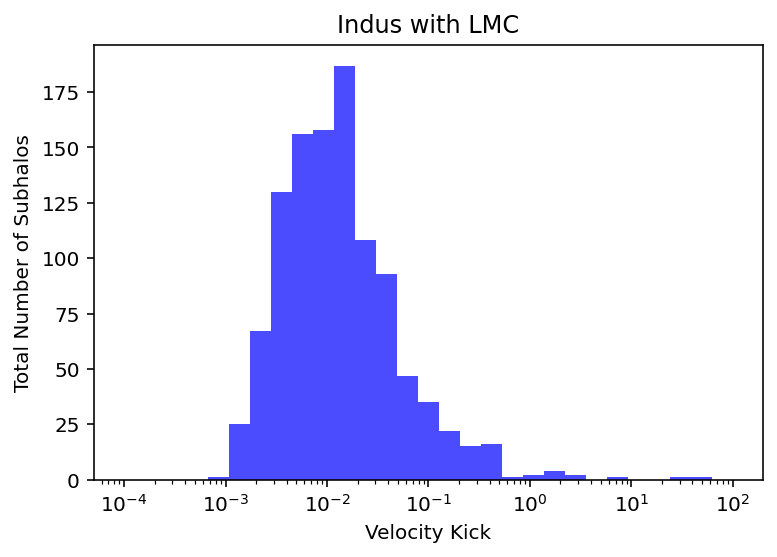

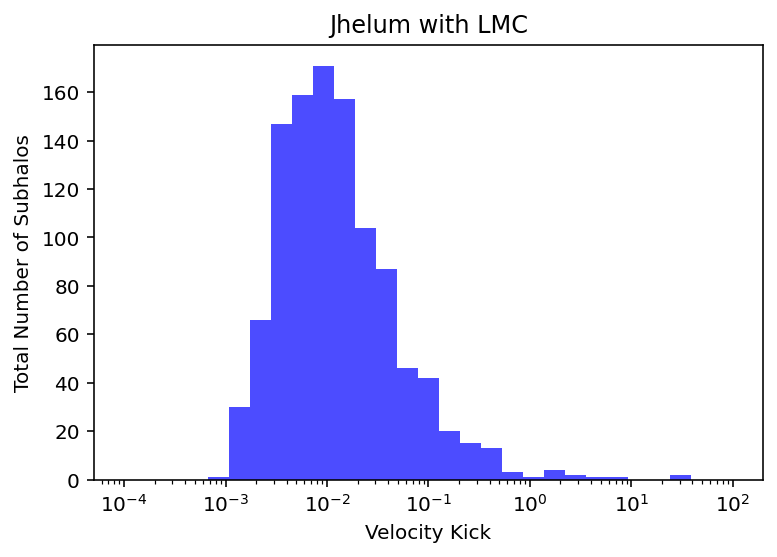

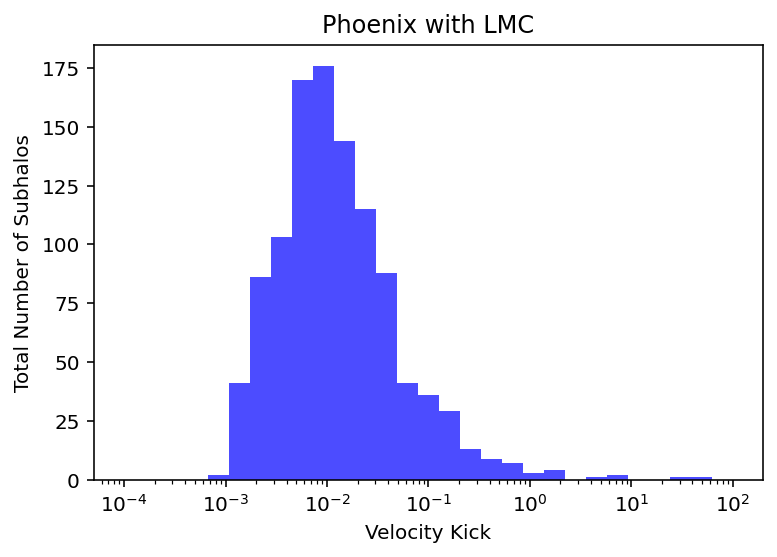

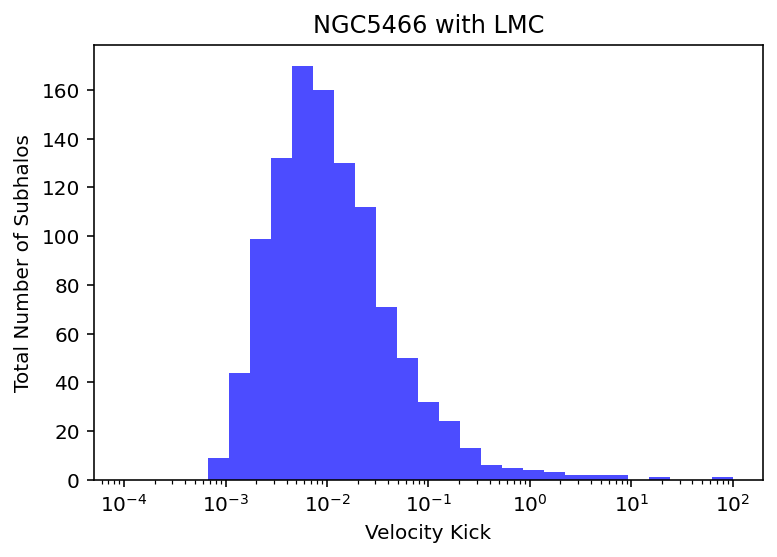

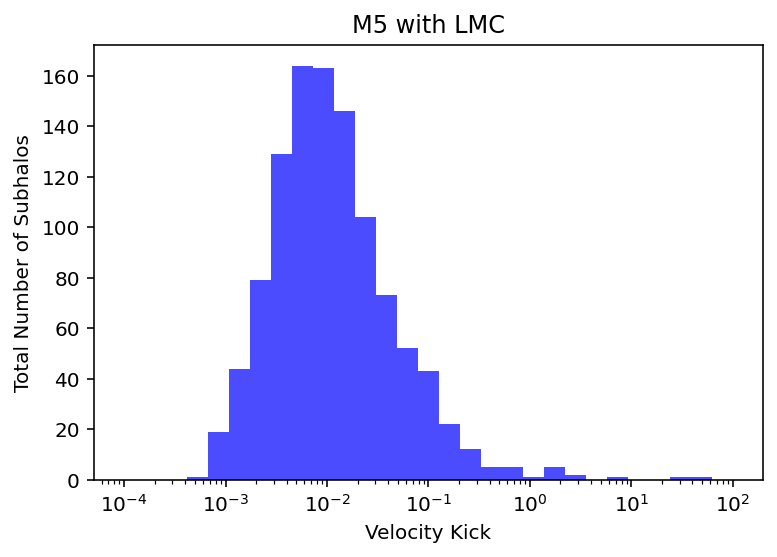

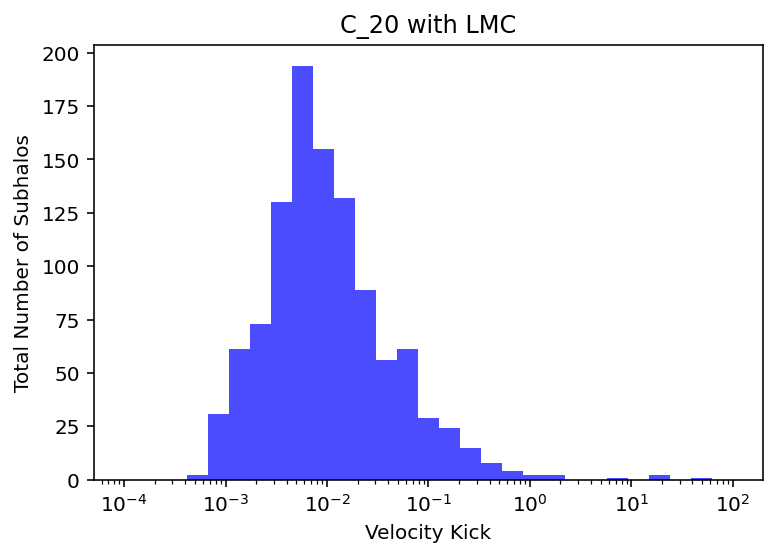

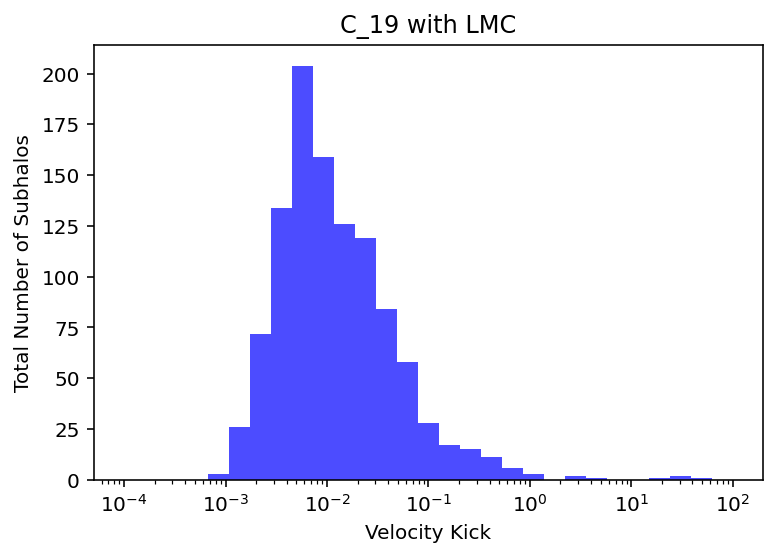

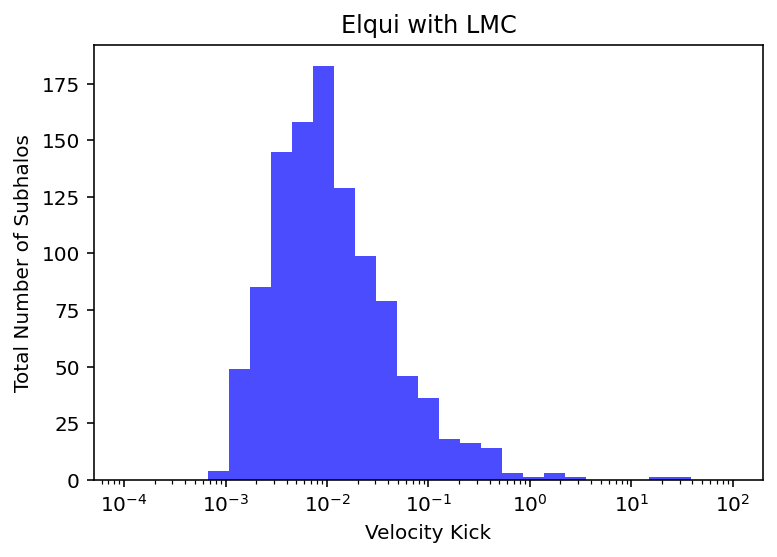

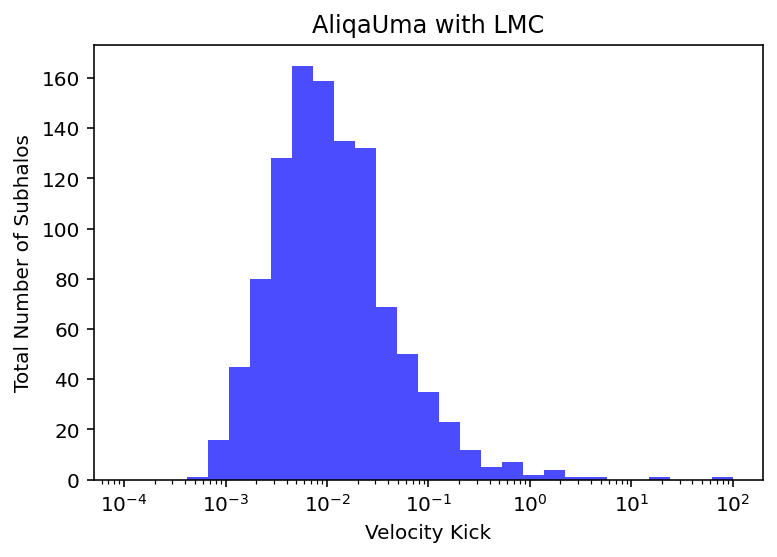

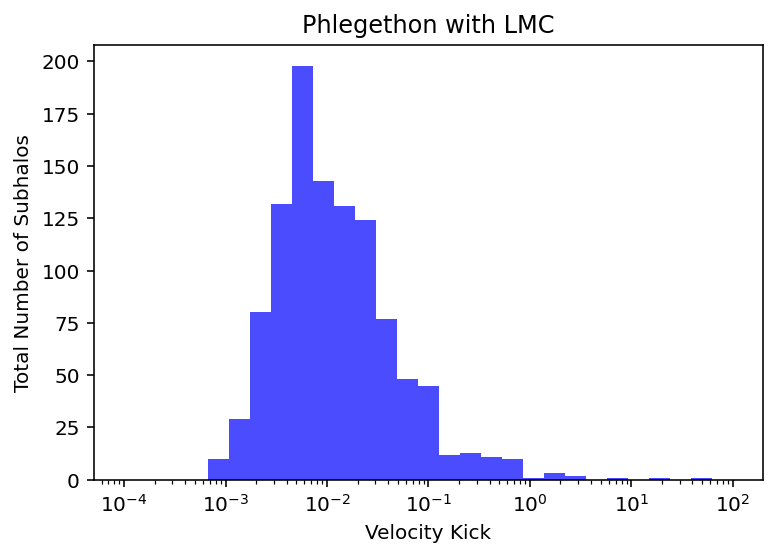

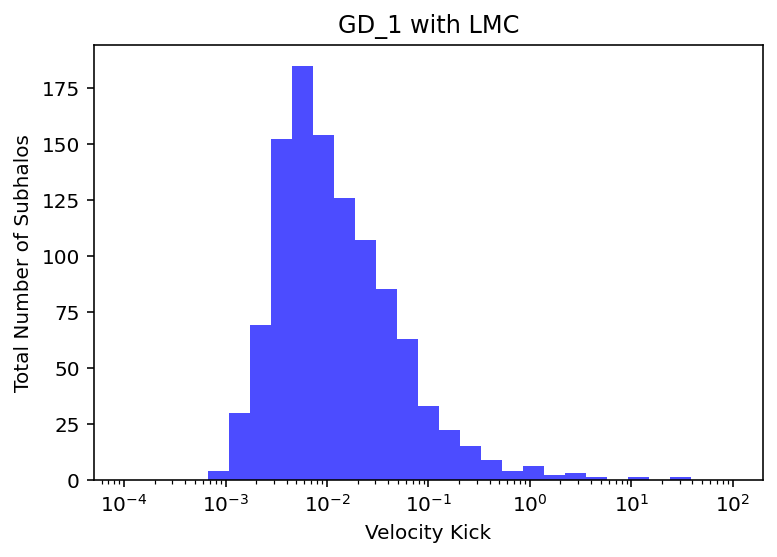

In [23]:

vel_kick = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#delta_v_individual_info = np.zeros(len(ts[ind_massive]['mvir'])) #creating an empty array to store ind delta v 
#there are 1072 contributions to velocity changes per stream
data_all = pd.DataFrame()
for i in range(len(pb)):
    
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    
    print(str(pb_new.iloc[i][0]), delta_v.to(u.km/u.s)[0])
    
    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb_new.iloc[i][0])+' with LMC')
    plt.savefig('Vel_Kick_Histogram_with_LMC/'+str(pb_new.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    
    vel_kick_temp = np.sqrt(np.sum(delta_v**2))
    vel_kick[i] = vel_kick_temp
vel_kick


    


<ipython-input-76-d7ef8e660abb>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Quantity [1.14120447e-04, 1.55389419e-04, 9.40564283e-05, 1.42048579e-04,
           1.88906893e-04, 1.15447824e-04, 1.11511685e-04, 2.39858700e-04,
           1.49917298e-04, 1.09090187e-04, 1.46664112e-04, 9.24341951e-05,
           1.17431721e-04, 2.04110559e-04, 2.13604740e-04, 1.24636526e-04,
           1.79443931e-04, 1.02165319e-04, 8.78517806e-05, 1.50202704e-04,
           1.47278251e-04, 1.67594280e-04, 2.16333669e-04, 1.31424278e-04,
           3.68194782e-04, 9.08101783e-04, 3.82980201e-04, 1.10862350e-04,
           1.36386224e-04, 1.34073574e-04] m3 solMass / (kg km kpc s)>

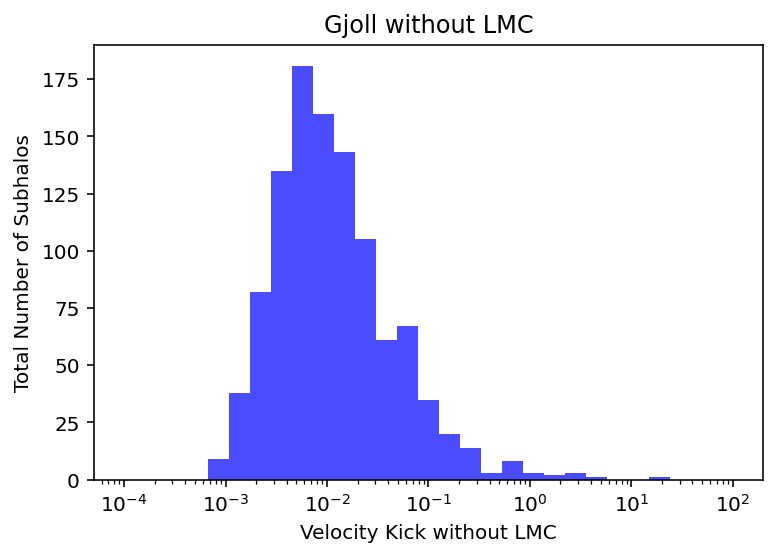

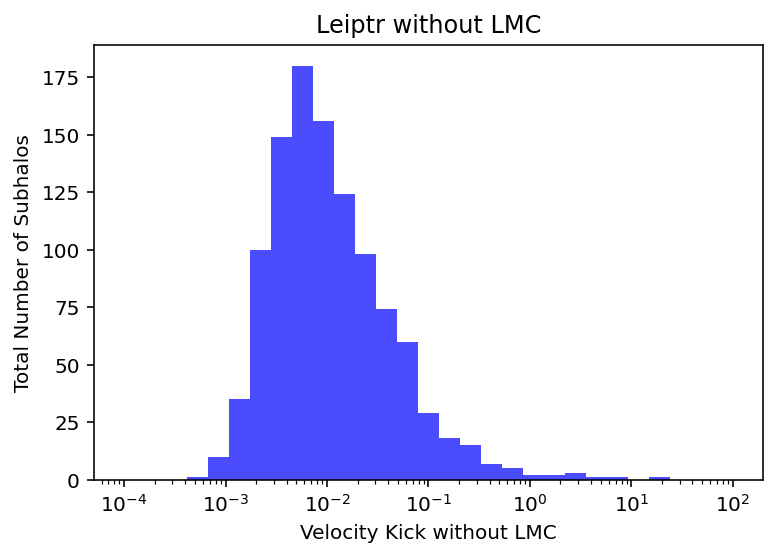

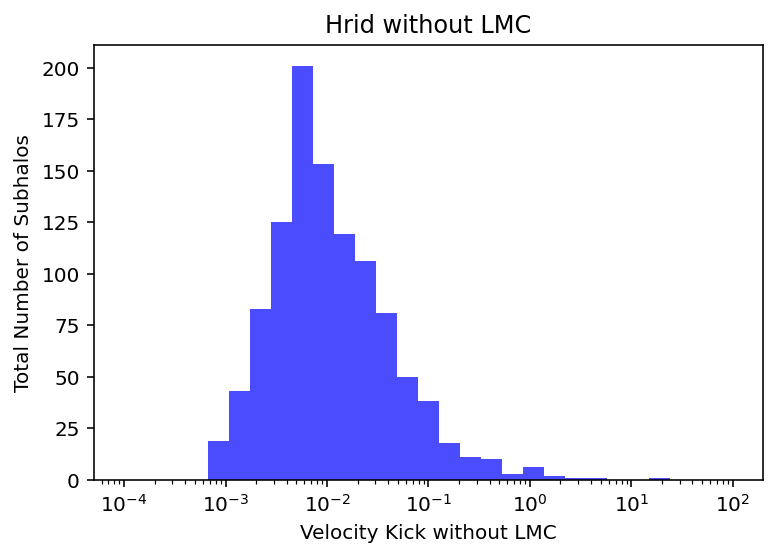

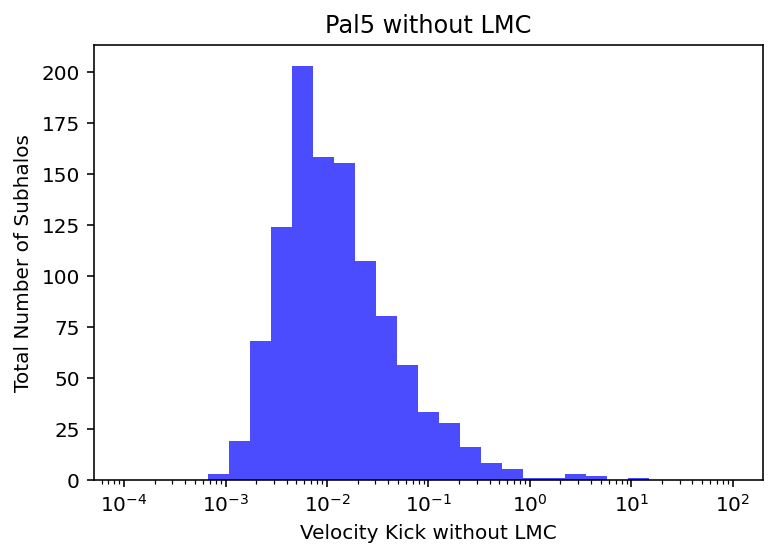

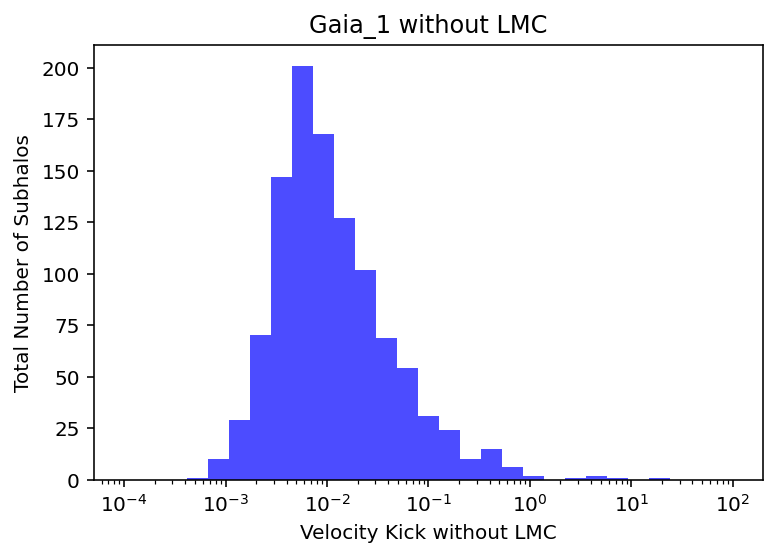

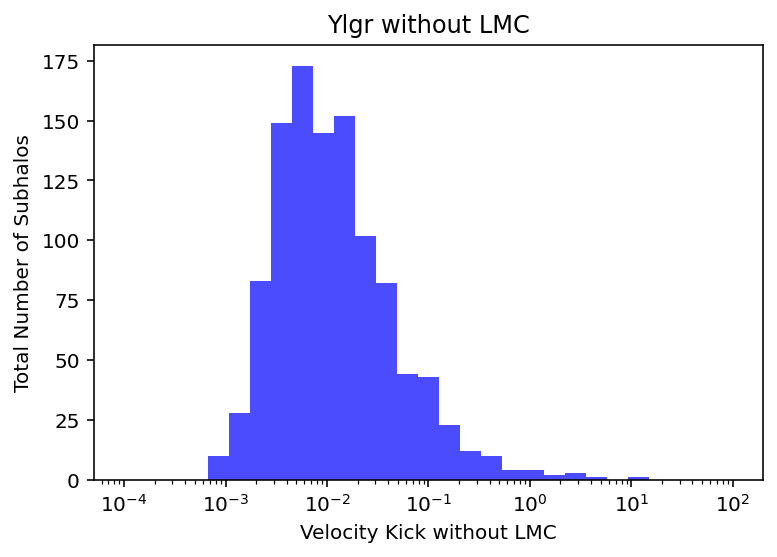

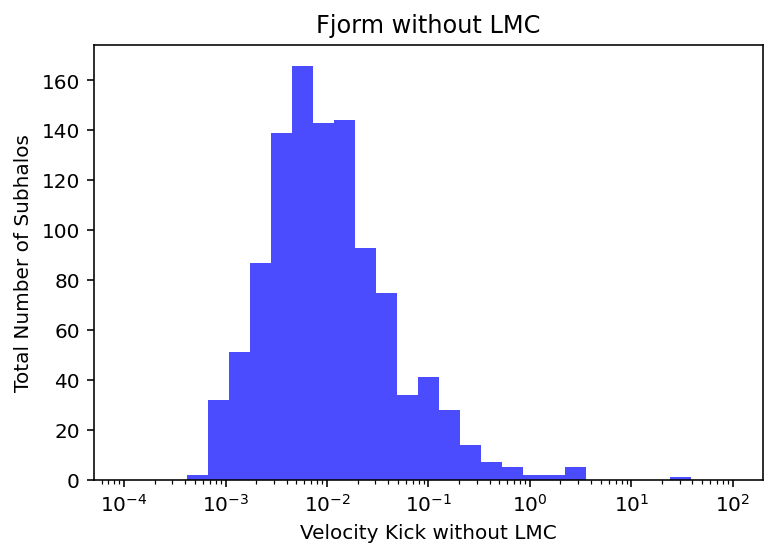

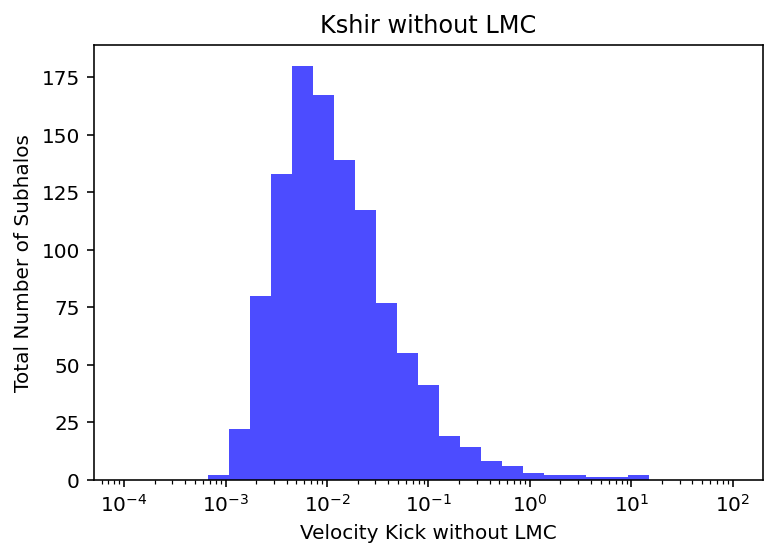

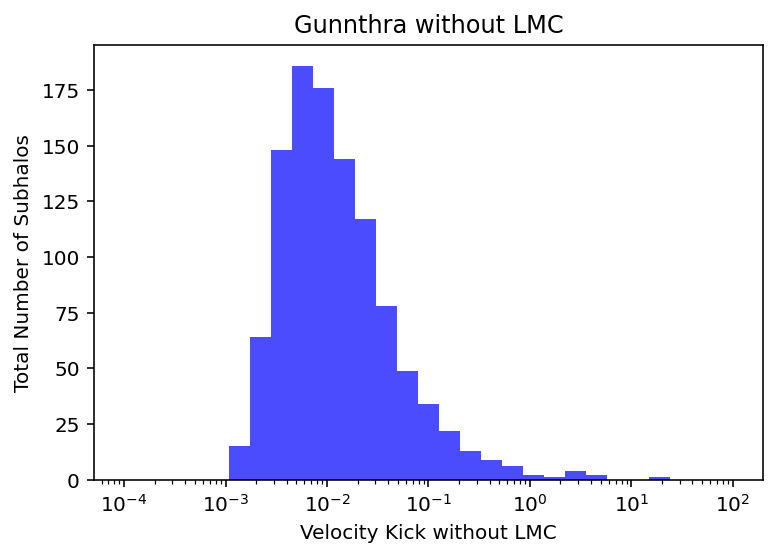

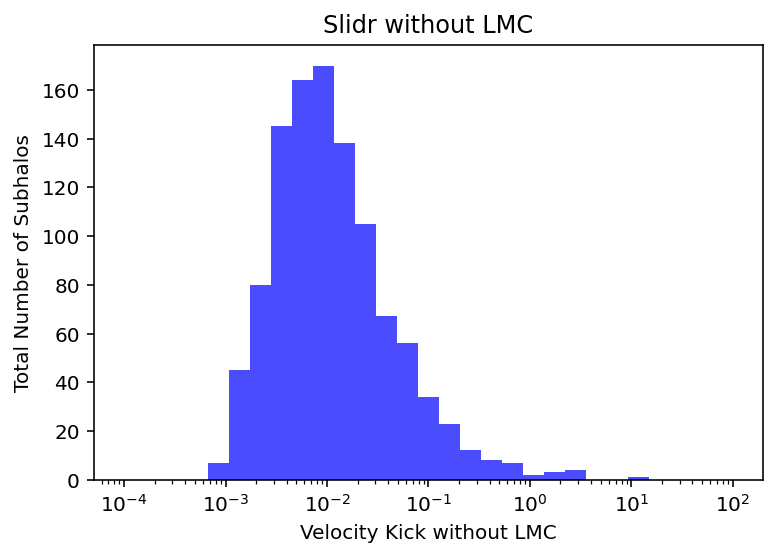

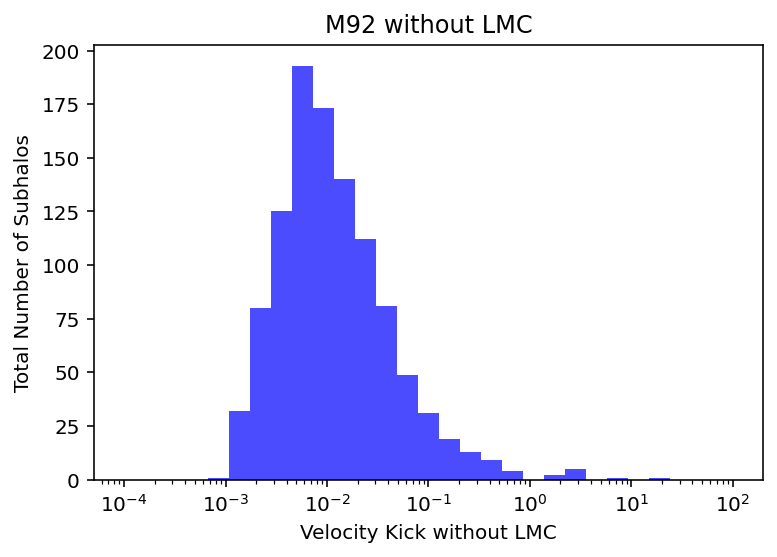

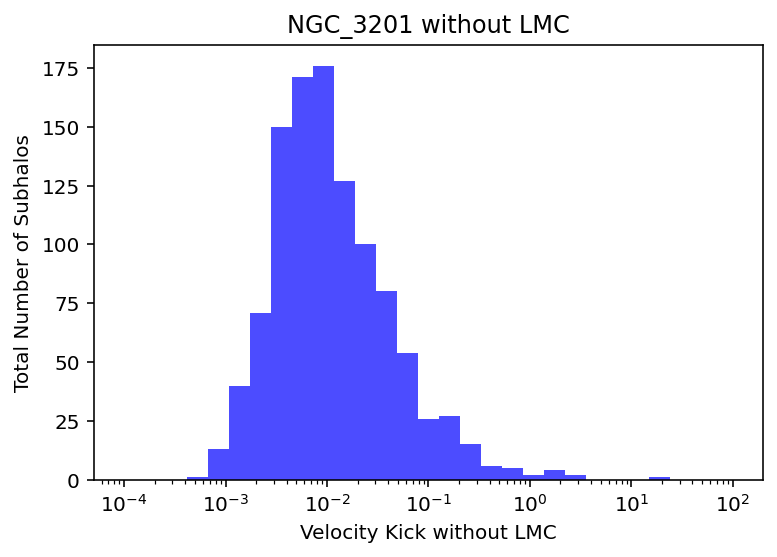

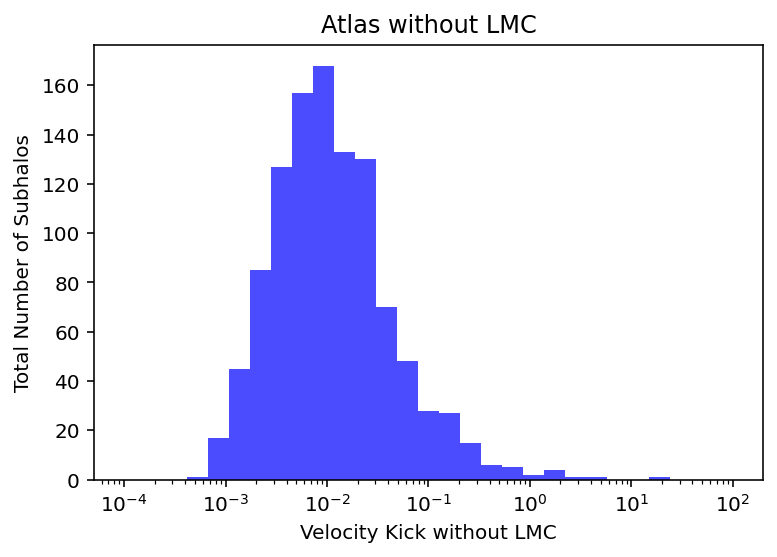

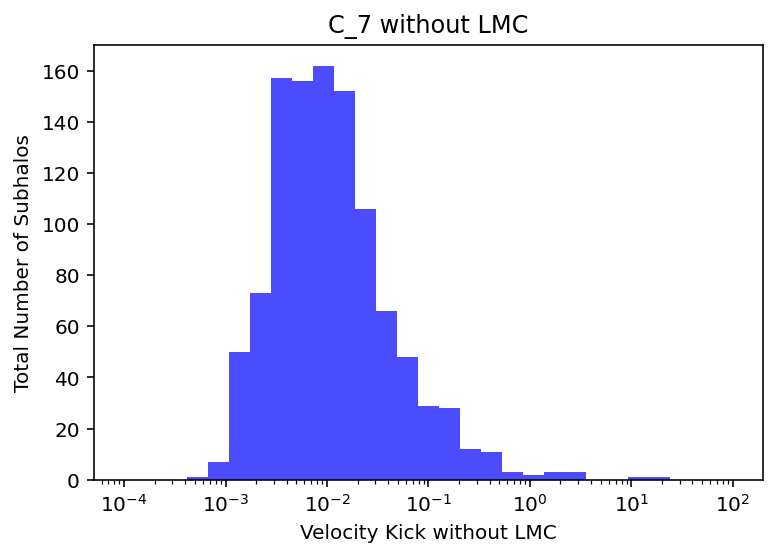

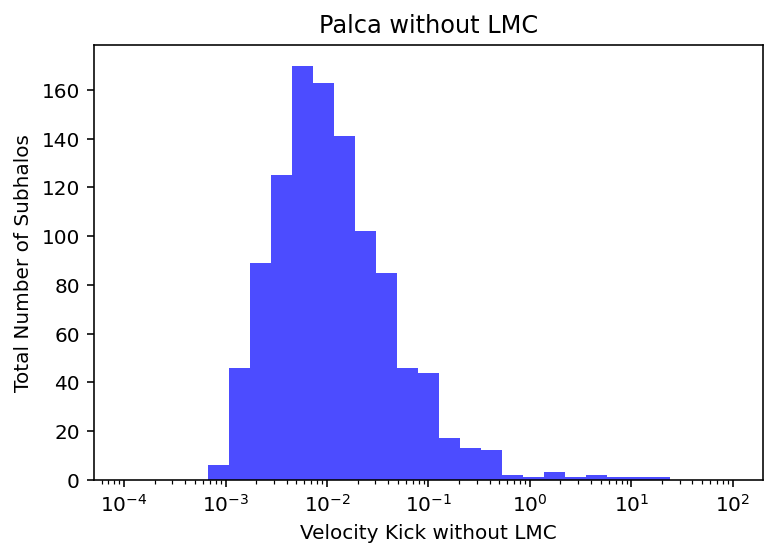

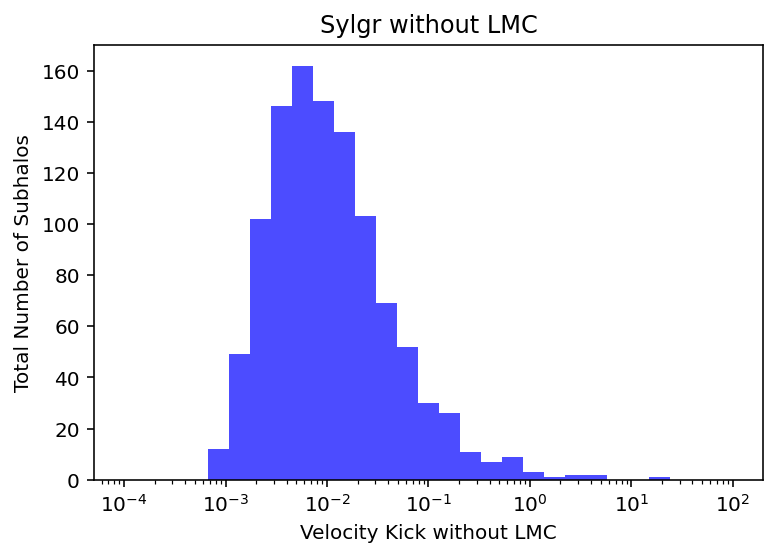

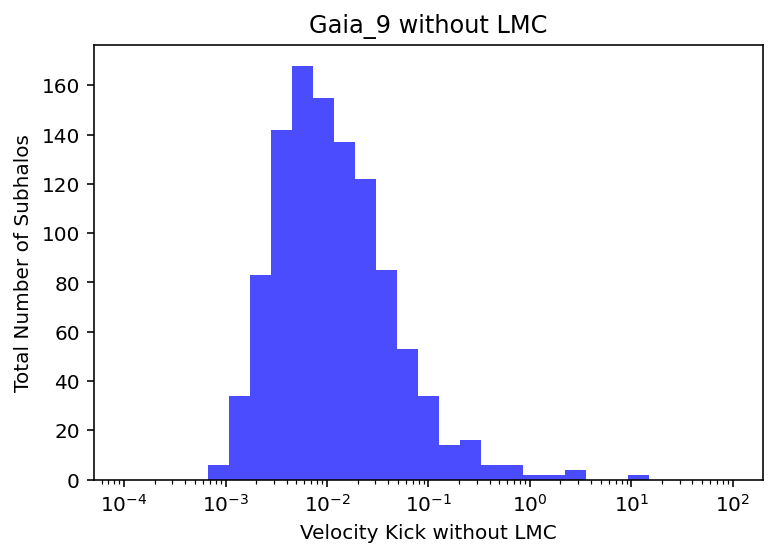

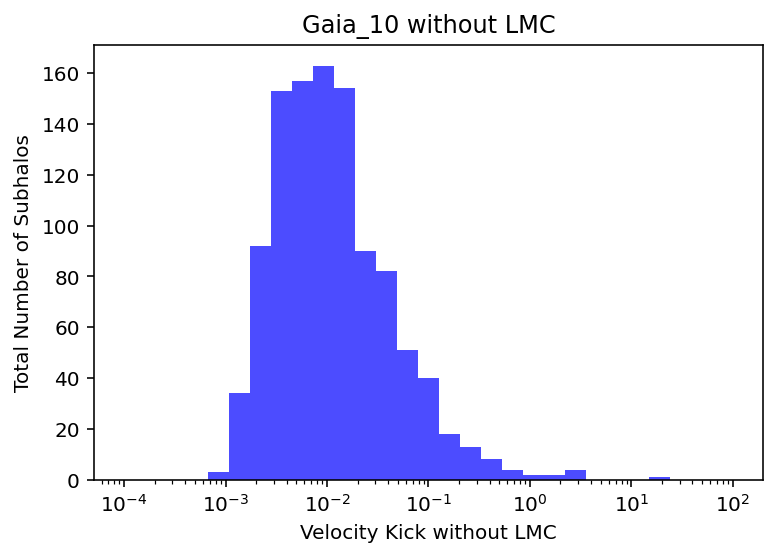

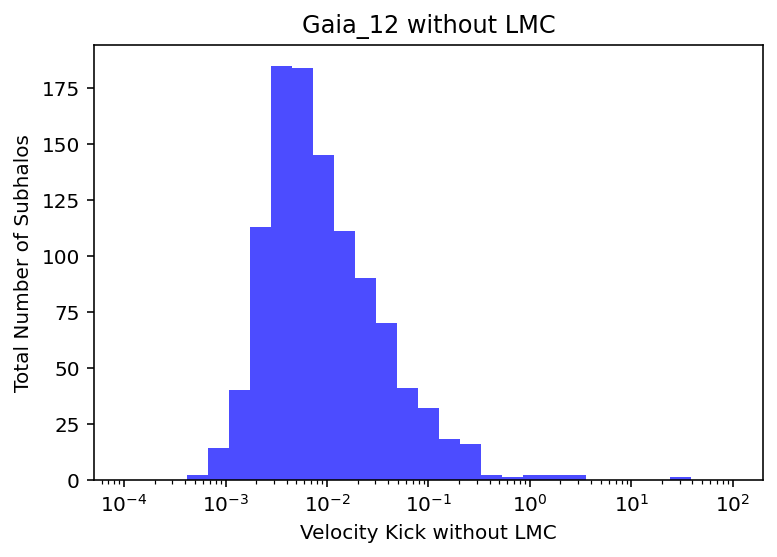

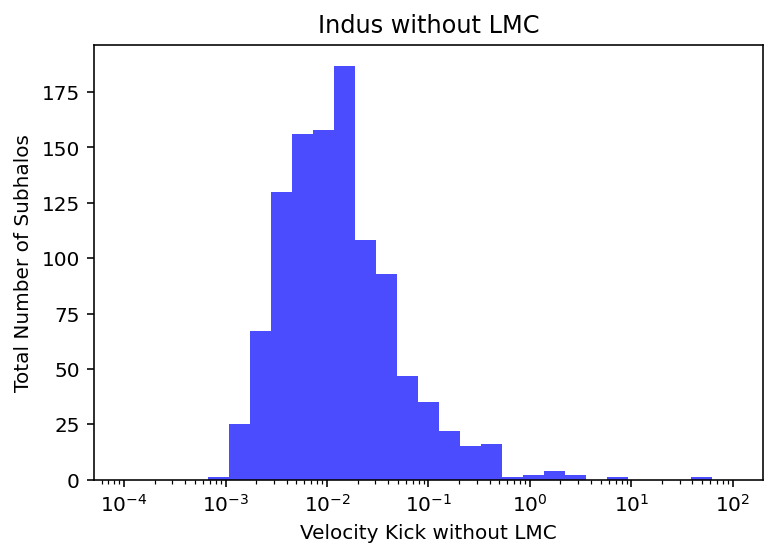

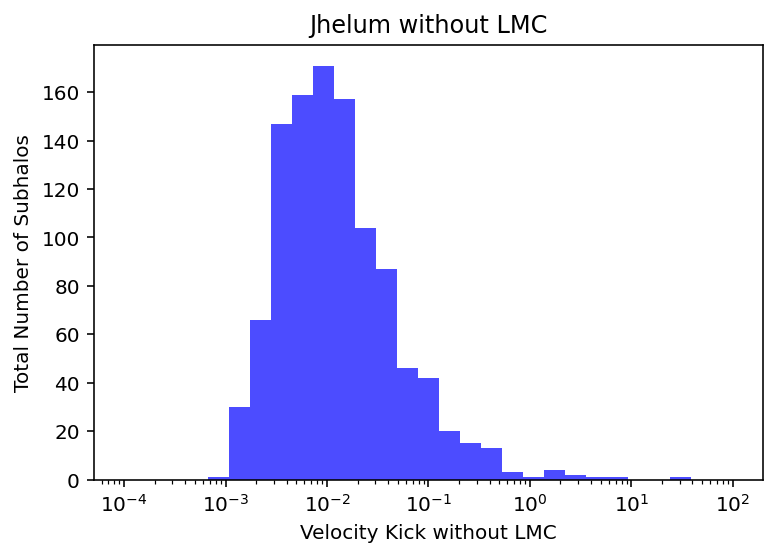

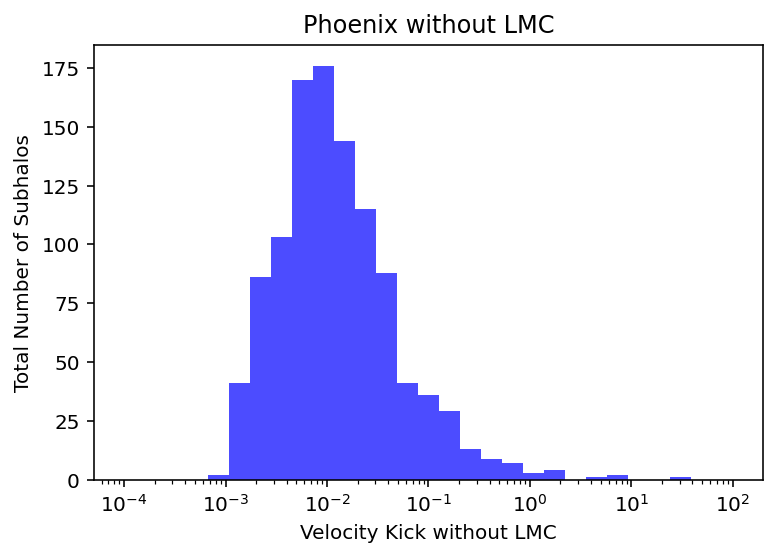

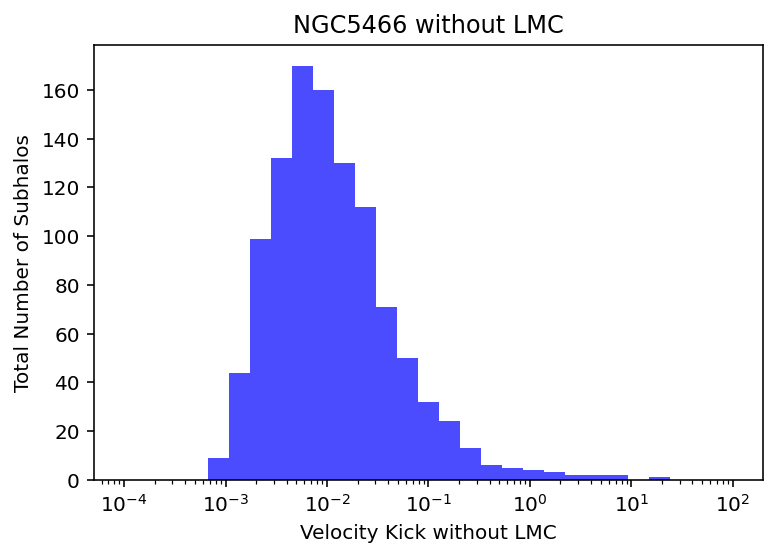

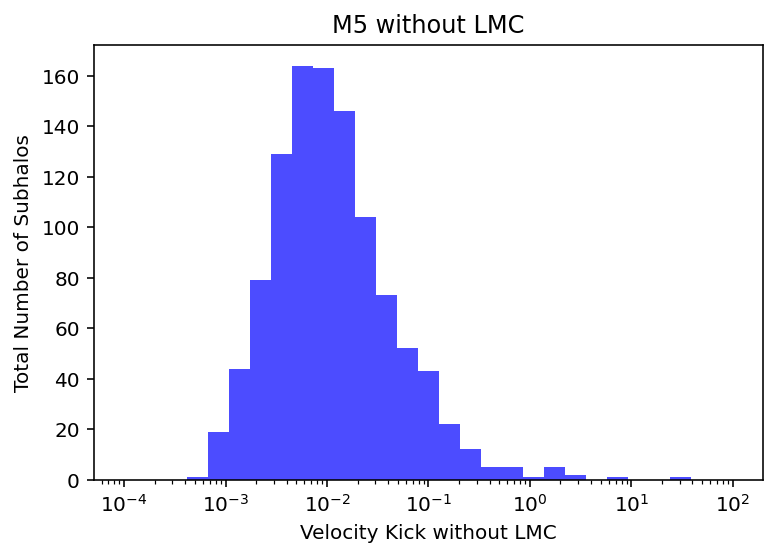

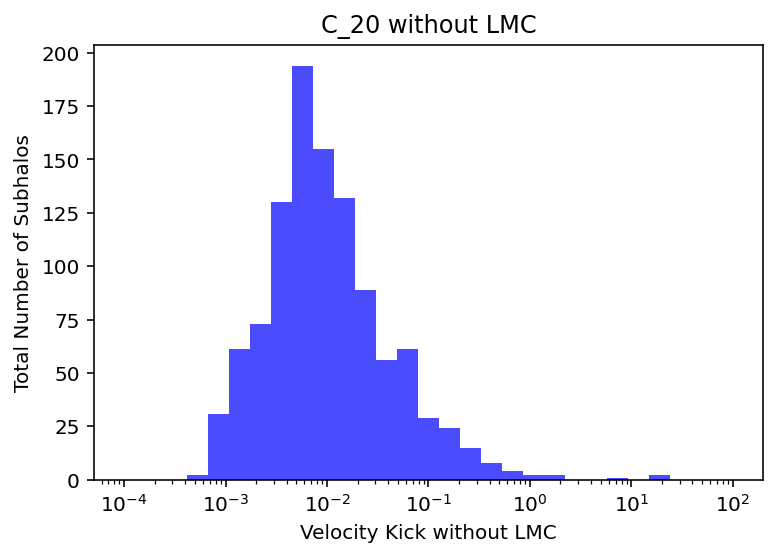

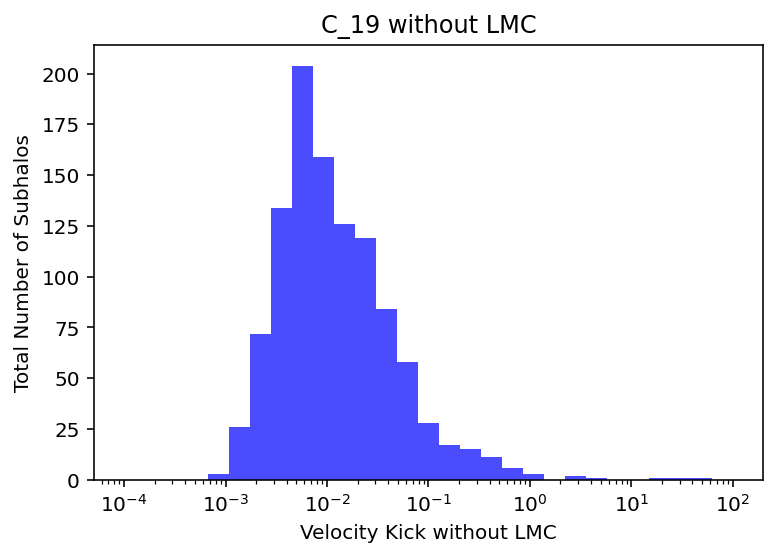

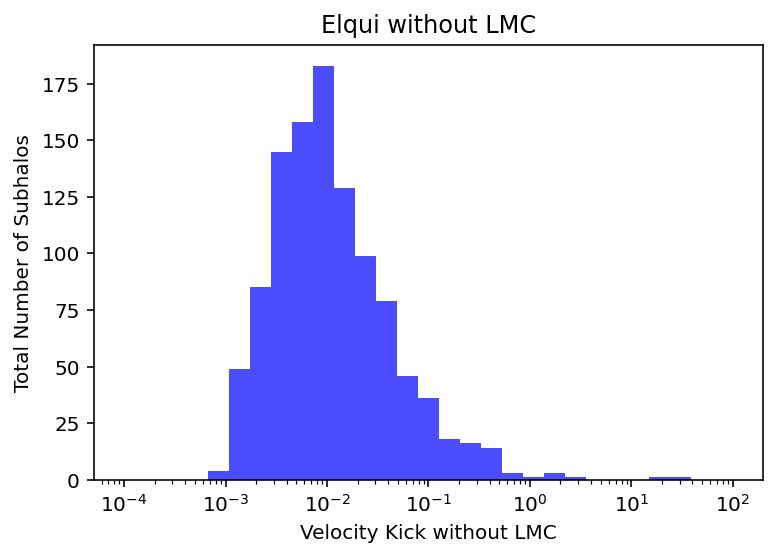

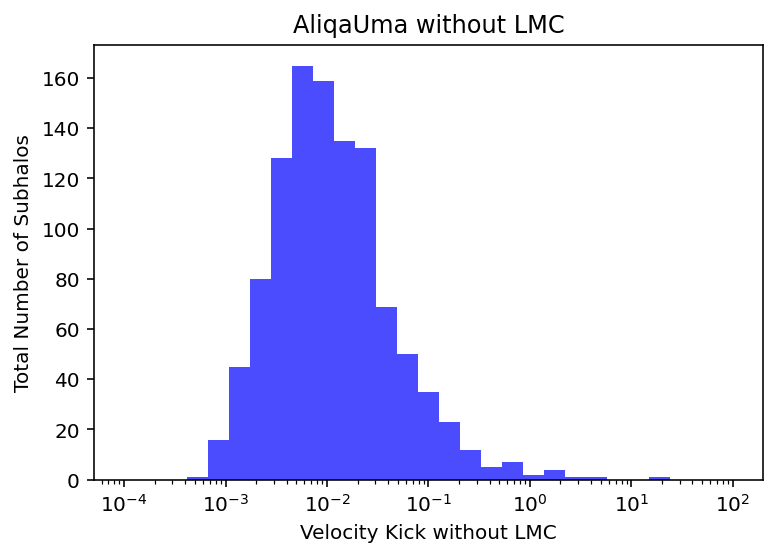

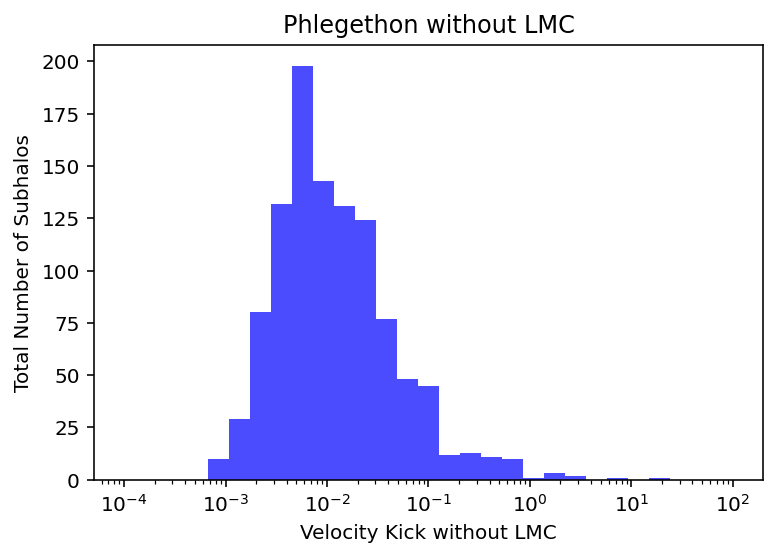

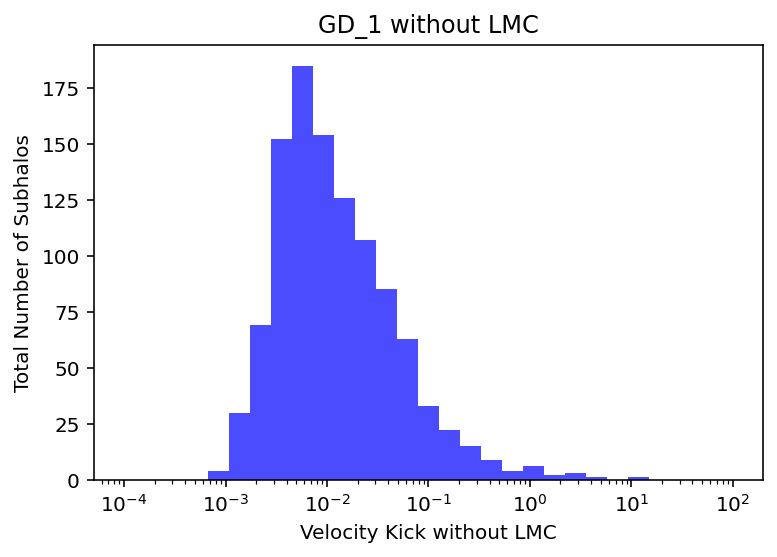

In [76]:
#Calculation of Velocity Kick Without LMC
# Add units 
vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#max_vel_kick_no_LMC = vel_kick_new
for i in range(len(pb)):
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb_new.iloc[i][1:])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
   
     
    #delta_v_max = np.max(delta_v)
    delta_v = delta_v[1:]
    
    plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    plt.hist(delta_v_km_new.value, bins=np.logspace(-4,2,30) , color='blue', alpha=0.7)
    plt.gca().set_xscale('log') 
    plt.xlabel('Velocity Kick without LMC')
    plt.ylabel('Total Number of Subhalos')
    plt.title(str(pb_new.iloc[i][0])+' without LMC')
    plt.savefig('Vel_Kick_Histogram_without_LMC/'+str(pb_new.iloc[i][0])+'.png', transparent=False, dpi=200) 
    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 

#use .decompe for SI units

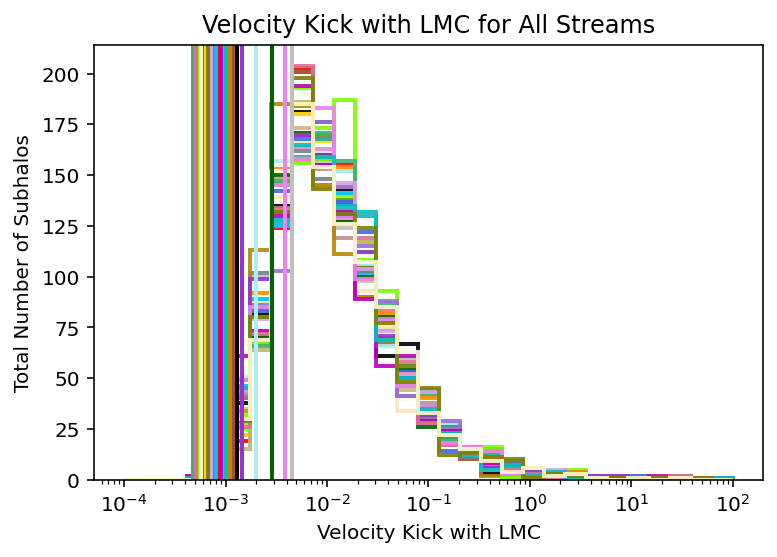

In [27]:
#Calculation of Velocity Kick Without LMC
# Add units 
colors = ['black', 'silver', 'rosybrown', 'red', 'sienna',
         'tan', 'moccasin', 'gold', 'darkkhaki', 'olivedrab', 
         'chartreuse', 'darkgreen', 'lightseagreen', 'paleturquoise',
         'deepskyblue', 'slategray', 'royalblue', 'darkorange', 'darkgoldenrod',
         'lawngreen', 'mediumseagreen', 'mediumpurple', 'darkorchid', 'plum', 
         'm', 'palevioletred', 'violet', 'c', 'olive', 'lemonchiffon', 'skyblue',
         'indigo']

vel_kick_no_LMC = (np.empty(len(pb)))*(u.m**3*u.M_sun/(u.kg*u.km*u.kpc*u.s))
#max_vel_kick_no_LMC = vel_kick_new
for i in range(len(pb)):   
    #Calculating Velocity Kick 
    G = (6.6743*10**(-11))*(u.m**3/(u.kg*u.s**2)) #gravitational constant
    r_min = np.array(pb.iloc[i][1::3])*u.kpc  #smallest distance between subhalos and stream 
    v_rel = np.array(pb.iloc[i][3::3])*(u.km/u.s) #relative vel btwn strean and subhalos 
    mass_subh = (np.array(ts[ind_massive]['mvir']))*u.M_sun #mass of subhalos
    delta_v = 2*G*mass_subh/(r_min*v_rel) #start with this one 
    
    #plt.figure()
    delta_v_km_new = delta_v.to(u.km/u.s)
    
    plt.hist(delta_v_km_new.value,bins=np.logspace(-4,2,30), color=colors[i], alpha=0.9,
         histtype='step', linewidth=2)
    plt.axvline(delta_v[0].value, color=colors[i], linewidth=2)
    
    plt.gca().set_xscale('log') 

    
    vel_kick_temp = np.sqrt(np.sum(delta_v[1:]**2))
    vel_kick_no_LMC[i] = vel_kick_temp
vel_kick_no_LMC 

plt.xlabel('Velocity Kick with LMC')
plt.ylabel('Total Number of Subhalos')
plt.title('Velocity Kick with LMC for All Streams')
plt.savefig('Vel_Kick_Histogram_with_LMC/All_Stream_Vel_Kick_With_LMC.png', transparent=False, dpi=200) 



In [51]:
streams['r_apo'] = np.nan
streams['r_peri'] = np.nan

In [52]:
streams_copy = streams.copy()

for i in range(len(streams['Stream'][:])):
    if streams['Stream'][i] in list(r_apo.keys()):
        streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
        streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]
        

<ipython-input-52-27d5bfcf547a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_apo'][i] = r_apo[streams['Stream'][i]]
<ipython-input-52-27d5bfcf547a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['r_peri'][i] = r_peri[streams['Stream'][i]]


In [53]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri  
0             78.73   27.4     8.5  
1            194.22   45.1    12.3  
2           -238.77   22.0     1.1  
3            -57.03   15.8     6.9  
4            214.91   67.6     8.2  
5            317.86   20.7    11.5  
6            -25.37   29.1     9.1  
7           -249.88   16.0    13.4  
8            132.26    7.2     4.2  
9             87.98   32.3     8.7  
10          -140.66   10.7     3.0  
11           489.63   30.5     8.5  
12           -85.65   32.4    11.7  
13            55.05   21.0     3.5  
14           106.32   16.5    10.8  
15          -184.80   24.6     8.7  
16          -359.86   20.8     8.7  
17           289.62   37.7     4.3  
18          -303.83  194.3    18.5  
19           -49.15   18.9    12.6  
20            -1.29   24.5     8.7  
21            45.92   18.1    11.7  
22            95.04   33.7     4.8  
23           -42.97   24.8     3.4  
24          -116.87   58.5    20.8  
25          -193.48   21.6     9.3  
26            15.86   54.0    12.1  
27           -42.33   31.9    11.6  
28            15.90   22.1     5.5  
29          -101.83   23.0    14.1

In [54]:
streams_copy.to_csv('Streams_data.csv', index='False')


In [28]:
streams = pd.read_csv('Streams_data.csv')
streams = streams.drop("Unnamed: 0",axis=1)

In [85]:
streams['vel_kick'] = np.nan

In [86]:
streams_copy = streams.copy()

vel_kick_km_s = vel_kick.to(u.km/u.s)
for i in range(len(streams['Stream'][:])):
    streams_copy['vel_kick'][i] = vel_kick_km_s[i]

<ipython-input-86-123d4aa28891>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy['vel_kick'][i] = vel_kick_km_s[i]


In [87]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863              NaN  
1            194.22   45.1    12.3  290.241352              NaN  
2           -238.77   22.0     1.1   48.045656              NaN  
3            -57.03   15.8     6.9   57.153605              NaN  
4            214.91   67.6     8.2   79.465647              NaN  
5            317.86   20.7    11.5   54.028556              NaN  
6            -25.37   29.1     9.1   46.494469              NaN  
7           -249.88   16.0    13.4   43.925118              NaN  
8            132.26    7.2     4.2   67.940894              NaN  
9             87.98   32.3     8.7   51.873998              NaN  
10          -140.66   10.7     3.0   67.260248              NaN  
11           489.63   30.5     8.5  187.721498              NaN  
12           -85.65   32.4    11.7   68.912629              NaN  
13            55.05   21.0     3.5  131.806263              NaN  
14           106.32   16.5    10.8   55.820556              NaN  
15          -184.80   24.6     8.7   38.359667              NaN  
16          -359.86   20.8     8.7   41.418034              NaN  
17           289.62   37.7     4.3   66.021964              NaN  
18          -303.83  194.3    18.5   75.461684              NaN  
19           -49.15   18.9    12.6   57.692290              NaN  
20            -1.29   24.5     8.7   44.930548              NaN  
21            45.92   18.1    11.7   52.291065              NaN  
22            95.04   33.7     4.8   96.872192              NaN  
23           -42.97   24.8     3.4   54.158798              NaN  
24          -116.87   58.5    20.8   65.107546              NaN  
25          -193.48   21.6     9.3   69.600493              NaN  
26            15.86   54.0    12.1  252.855823              NaN  
27           -42.33   31.9    11.6   67.229462              NaN  
28            15.90   22.1     5.5   47.903083              NaN  
29          

In [88]:
streams_copy.to_csv('Streams_data_with_velkick.csv', index='False')

In [90]:
streams_copy

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863              NaN  
1            194.22   45.1    12.3  290.241352              NaN  
2           -238.77   22.0     1.1   48.045656              NaN  
3            -57.03   15.8     6.9   57.153605              NaN  
4            214.91   67.6     8.2   79.465647              NaN  
5            317.86   20.7    11.5   54.028556              NaN  
6            -25.37   29.1     9.1   46.494469              NaN  
7           -249.88   16.0    13.4   43.925118              NaN  
8            132.26    7.2     4.2   67.940894              NaN  
9             87.98   32.3     8.7   51.873998              NaN  
10          -140.66   10.7     3.0   67.260248              NaN  
11           489.63   30.5     8.5  187.721498              NaN  
12           -85.65   32.4    11.7   68.912629              NaN  
13            55.05   21.0     3.5  131.806263              NaN  
14           106.32   16.5    10.8   55.820556              NaN  
15          -184.80   24.6     8.7   38.359667              NaN  
16          -359.86   20.8     8.7   41.418034              NaN  
17           289.62   37.7     4.3   66.021964              NaN  
18          -303.83  194.3    18.5   75.461684              NaN  
19           -49.15   18.9    12.6   57.692290              NaN  
20            -1.29   24.5     8.7   44.930548              NaN  
21            45.92   18.1    11.7   52.291065              NaN  
22            95.04   33.7     4.8   96.872192              NaN  
23           -42.97   24.8     3.4   54.158798              NaN  
24          -116.87   58.5    20.8   65.107546              NaN  
25          -193.48   21.6     9.3   69.600493              NaN  
26            15.86   54.0    12.1  252.855823              NaN  
27           -42.33   31.9    11.6   67.229462              NaN  
28            15.90   22.1     5.5   47.903083              NaN  
29          

In [91]:
streams_copy['vel_kick_no_LMC'] = np.nan

In [92]:
streams_copy_new = streams_copy.copy()

vel_kick_no_LMC_km_s = vel_kick_no_LMC.to(u.km/u.s)
for i in range(len(streams['Stream'][:])):
    streams_copy_new['vel_kick_no_LMC'][i] = vel_kick_no_LMC_km_s[i]

<ipython-input-92-f418d5b2479f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  streams_copy_new['vel_kick_no_LMC'][i] = vel_kick_no_LMC_km_s[i]


In [93]:
streams_copy_new

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863        20.434221  
1            194.22   45.1    12.3  290.241352        19.290136  
2           -238.77   22.0     1.1   48.045656        20.309230  
3            -57.03   15.8     6.9   57.153605        17.339283  
4            214.91   67.6     8.2   79.465647        20.213433  
5            317.86   20.7    11.5   54.028556        15.694849  
6            -25.37   29.1     9.1   46.494469        26.273828  
7           -249.88   16.0    13.4   43.925118        19.010165  
8            132.26    7.2     4.2   67.940894        17.895889  
9             87.98   32.3     8.7   51.873998        15.520480  
10          -140.66   10.7     3.0   67.260248        19.749363  
11           489.63   30.5     8.5  187.721498        19.620481  
12           -85.65   32.4    11.7   68.912629        17.678834  
13            55.05   21.0     3.5  131.806263        26.347777  
14           106.32   16.5    10.8   55.820556        21.431967  
15          -184.80   24.6     8.7   38.359667        20.777941  
16          -359.86   20.8     8.7   41.418034        16.088737  
17           289.62   37.7     4.3   66.021964        19.030668  
18          -303.83  194.3    18.5   75.461684        24.809409  
19           -49.15   18.9    12.6   57.692290        47.023070  
20            -1.29   24.5     8.7   44.930548        32.808196  
21            45.92   18.1    11.7   52.291065        27.835622  
22            95.04   33.7     4.8   96.872192        23.295723  
23           -42.97   24.8     3.4   54.158798        28.397205  
24          -116.87   58.5    20.8   65.107546        29.129016  
25          -193.48   21.6     9.3   69.600493        61.200506  
26            15.86   54.0    12.1  252.855823        32.580607  
27           -42.33   31.9    11.6   67.229462        17.618005  
28            15.90   22.1     5.5   47.903083        20.388100  
29          

In [94]:
streams_copy_new.to_csv('Streams_data_with_velkick_NO_LMC.csv', index='False')

In [25]:
streams_copy_new = pd.read_csv('Streams_data_with_velkick_NO_LMC.csv')
streams_copy_new = streams_copy_new.drop("Unnamed: 0",axis=1)

In [26]:
streams_copy_new

Stream      ra    dec  distance  pm_ra_cosdec  pm_dec  \
0        Gjoll   82.10 -13.95      3.26         23.58  -23.70   
1       Leiptr   89.11 -28.37      7.39         10.59   -9.90   
2         Hrid  280.51  33.30      2.75         -5.88   20.08   
3         Pal5  229.65   0.26     20.16         -2.75   -2.68   
4       Gaia_1  190.96  -9.16      5.57        -14.39  -19.72   
5         Ylgr  173.82 -22.31      9.72         -0.44   -7.65   
6        Fjorm  251.89  65.38      6.42          3.92    3.10   
7        Kshir  205.88  67.25      9.57         -7.67   -3.92   
8     Gunnthra  284.22 -73.49      2.83        -15.83  -24.04   
9        Slidr  160.05  10.22      2.99        -24.60   -6.65   
10         M92  259.89  43.08      8.94         -5.15   -0.63   
11    NGC_3201  152.46 -46.32      4.99          8.87   -2.22   
12       Atlas   25.04 -29.81     19.93          0.04   -0.89   
13         C_7  287.15 -50.17      6.77        -13.79  -12.38   
14       Palca   36.57 -36.15     12.31          0.90   -0.23   
15       Sylgr  179.68  -2.44      3.77        -13.98  -12.90   
16      Gaia_9  233.27  60.42      4.68        -12.49    6.37   
17     Gaia_10  161.47  15.17     13.32         -4.14   -3.15   
18     Gaia_12   41.05  16.45     15.71          5.84   -5.66   
19       Indus  340.12 -60.58     14.96          3.59   -4.89   
20      Jhelum  351.95 -51.74     11.39          7.23   -4.37   
21     Phoenix   23.96 -50.01     16.80          2.72   -0.07   
22     NGC5466  214.41  26.84     14.09         -5.64   -0.72   
23          M5  206.96  13.50      7.44          3.50   -8.76   
24        C_20  359.81   8.63     18.11         -0.58    1.44   
25        C_19  355.28  28.82     18.04          1.25   -2.74   
26       Elqui   19.77 -42.36     51.41          0.33   -0.49   
27    AliqaUma   34.08 -33.97     21.98          0.24   -0.79   
28  Phlegethon  319.89 -32.07      3.29         -3.97  -37.66   
29        GD_1  160.02  45.90      8.06         -6.75  -10.88   

    radial_velocity  r_apo  r_peri    vel_kick  vel_kick_no_LMC  
0             78.73   27.4     8.5   85.281863        20.434221  
1            194.22   45.1    12.3  290.241352        19.290136  
2           -238.77   22.0     1.1   48.045656        20.309230  
3            -57.03   15.8     6.9   57.153605        17.339283  
4            214.91   67.6     8.2   79.465647        20.213433  
5            317.86   20.7    11.5   54.028556        15.694849  
6            -25.37   29.1     9.1   46.494469        26.273828  
7           -249.88   16.0    13.4   43.925118        19.010165  
8            132.26    7.2     4.2   67.940894        17.895889  
9             87.98   32.3     8.7   51.873998        15.520480  
10          -140.66   10.7     3.0   67.260248        19.749363  
11           489.63   30.5     8.5  187.721498        19.620481  
12           -85.65   32.4    11.7   68.912629        17.678834  
13            55.05   21.0     3.5  131.806263        26.347777  
14           106.32   16.5    10.8   55.820556        21.431967  
15          -184.80   24.6     8.7   38.359667        20.777941  
16          -359.86   20.8     8.7   41.418034        16.088737  
17           289.62   37.7     4.3   66.021964        19.030668  
18          -303.83  194.3    18.5   75.461684        24.809409  
19           -49.15   18.9    12.6   57.692290        47.023070  
20            -1.29   24.5     8.7   44.930548        32.808196  
21            45.92   18.1    11.7   52.291065        27.835622  
22            95.04   33.7     4.8   96.872192        23.295723  
23           -42.97   24.8     3.4   54.158798        28.397205  
24          -116.87   58.5    20.8   65.107546        29.129016  
25          -193.48   21.6     9.3   69.600493        61.200506  
26            15.86   54.0    12.1  252.855823        32.580607  
27           -42.33   31.9    11.6   67.229462        17.618005  
28            15.90   22.1     5.5   47.903083        20.388100  
29          

Text(0.5, 1.0, 'Streams Apocenter vs Pericenter')

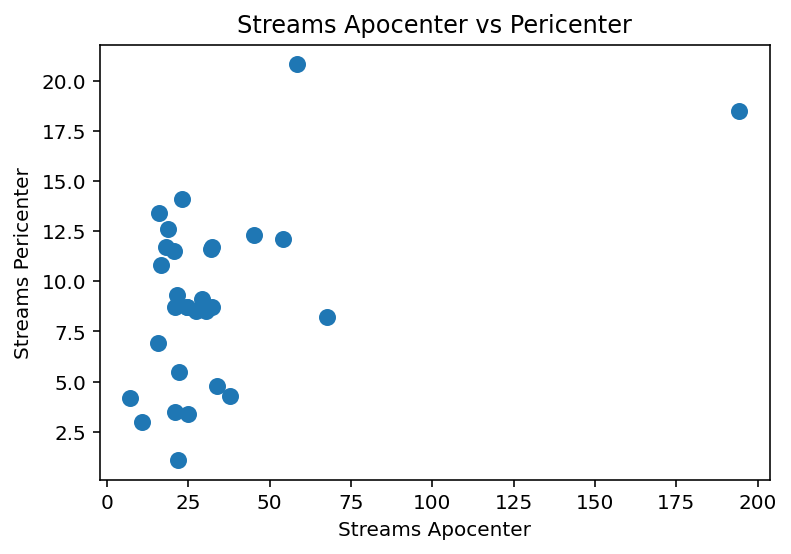

In [25]:
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['r_peri'], '.', ms=15)
plt.xlabel('Streams Apocenter')
plt.ylabel('Streams Pericenter')
plt.title('Streams Apocenter vs Pericenter')
#plt.gca().set_aspect('equal', adjustable='datalim')

In [36]:
corr_apo_peri = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['r_peri'])
corr_apo_peri

array([[1.        , 0.49676505],
       [0.49676505, 1.        ]])

Text(0.5, 1.0, 'Streams Pericenter vs Velocity Kick')

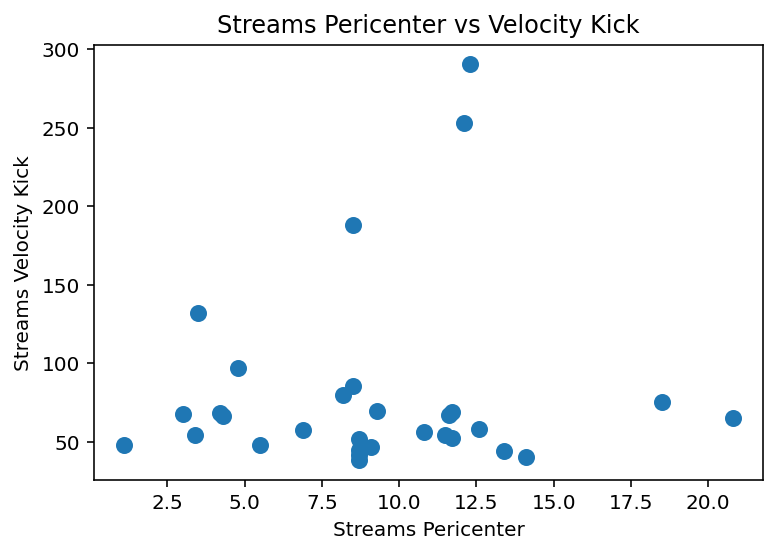

In [105]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Pericenter vs Velocity Kick')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [37]:
corr_peri_velkick = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick'])
corr_peri_velkick

array([[1.        , 0.09029779],
       [0.09029779, 1.        ]])

Text(0.5, 1.0, 'Streams Apo vs Velocity Kick')

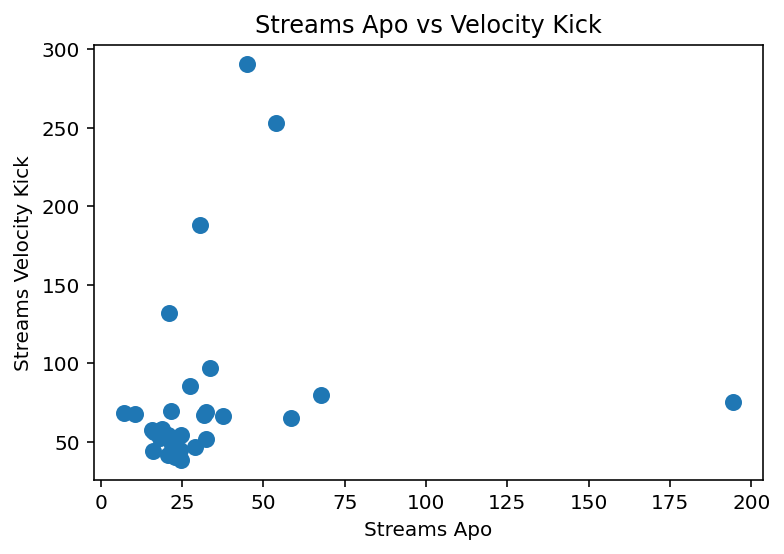

In [26]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick')
plt.title('Streams Apo vs Velocity Kick')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [38]:
corr_apo_velkick = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick'])
corr_apo_velkick

array([[1.        , 0.16953206],
       [0.16953206, 1.        ]])

Text(0.5, 1.0, 'Streams Pericenter vs Velocity Kick No LMC')

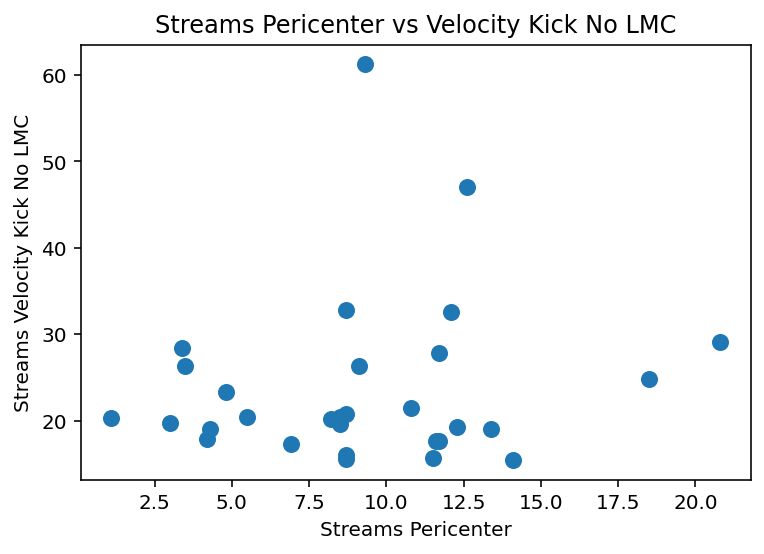

In [116]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Pericenter')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Pericenter vs Velocity Kick No LMC')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [39]:
corr_peri_velkicknoLMC = np.corrcoef(streams_copy_new['r_peri'], streams_copy_new['vel_kick_no_LMC'])
corr_peri_velkicknoLMC

array([[1.        , 0.13498624],
       [0.13498624, 1.        ]])

Text(0.5, 1.0, 'Streams Apo vs Velocity Kick No LMC')

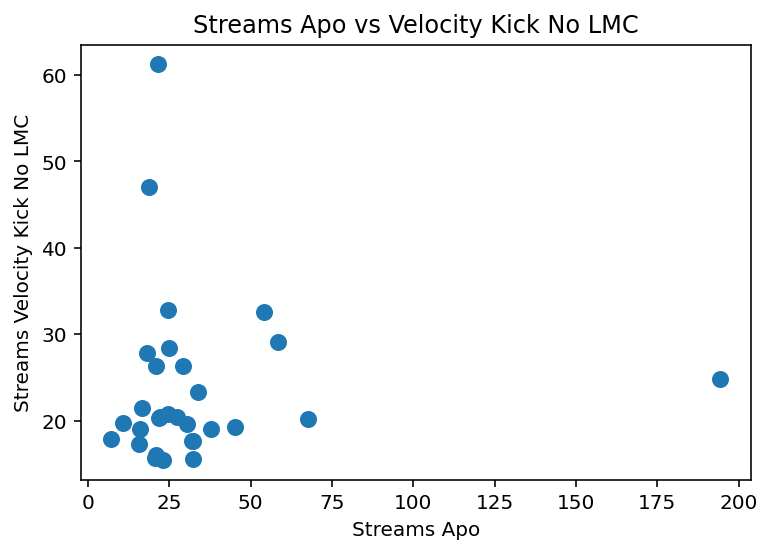

In [27]:
#x = np.linspace(0,300,10)
plt.figure()
plt.plot(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'], '.', ms=15)
plt.xlabel('Streams Apo')
plt.ylabel('Streams Velocity Kick No LMC')
plt.title('Streams Apo vs Velocity Kick No LMC')
#plt.plot(x, x)
#plt.xlim(0, 75)
#plt.gca().set_aspect('equal', adjustable='datalim')

In [40]:
corr_apo_velkicknoLMC = np.corrcoef(streams_copy_new['r_apo'], streams_copy_new['vel_kick_no_LMC'])
corr_apo_velkicknoLMC

array([[1.        , 0.02248158],
       [0.02248158, 1.        ]])

In [21]:
diff_velkicks = np.abs(streams_copy_new['vel_kick_no_LMC'] - streams_copy_new['vel_kick'])
#diff_velkicks

0      64.847642
1     270.951215
2      27.736426
3      39.814322
4      59.252214
5      38.333706
6      20.220641
7      24.914953
8      50.045005
9      36.353518
10     47.510886
11    168.101017
12     51.233794
13    105.458487
14     34.388589
15     17.581726
16     25.329297
17     46.991297
18     50.652276
19     10.669220
20     12.122353
21     24.455443
22     73.576469
23     25.761592
24     35.978530
25      8.399987
26    220.275215
27     49.611457
28     27.514983
29     24.753259
dtype: float64

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Absolute Difference in Velocity Kicks Per Stream')

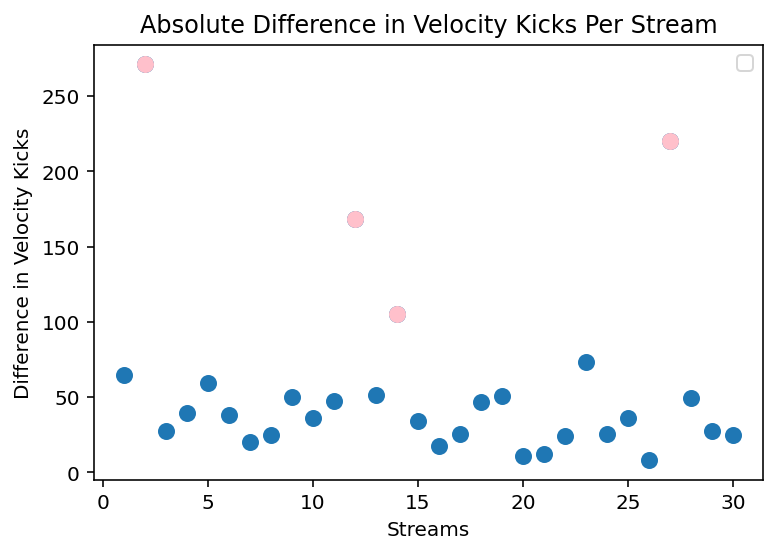

In [22]:
x = np.linspace(1,30,30)
plt.figure()
plt.plot(x, diff_velkicks, '.', ms=15)
plt.plot(x[diff_velkicks>100], diff_velkicks[diff_velkicks>100], '.', 
         color= 'pink', ms=15) #label=str(streams_copy_new['Stream'][diff_velkicks>100]) + ':' + 

# feed back from lmc generically heats up the streams 
#str(mwsts[str(streams_copy_new['Stream'][diff_velkicks>100])].length.deg))
#Need Help Adding Names 

plt.xlabel('Streams')
plt.ylabel('Difference in Velocity Kicks')
plt.legend(loc='best')
plt.title('Absolute Difference in Velocity Kicks Per Stream')

In [56]:
streams_copy_new['Stream'][diff_velkicks>100]

1       Leiptr
11    NGC_3201
13         C_7
26       Elqui
Name: Stream, dtype: object

In [ ]:
Getting Max Velocity Kicks 

In [110]:
for i in range(len(streams_copy_new)):
    if streams_copy_new['vel_kick'][i] > 150:
        print(streams_copy_new['Stream'][i])
    

Leiptr
NGC_3201
Elqui


In [114]:
for i in range(len(streams_copy_new)):
    if streams_copy_new['vel_kick_no_LMC'][i] > 40:
        print(streams_copy_new['Stream'][i])

Indus
C_19


In [ ]:
#Smallest Distance on y axis and apocenter on x axis for all streams

In [18]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

#define hamiltonian
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))

def ClosestDistNoTime(streams):
    #Information for Stream 
    closest_dist1 = pd.DataFrame()
    for i in range(len(streams)): #goes through every stream
        c = coord.SkyCoord(ra=streams.iloc[i]['ra']*u.deg, dec=streams.iloc[i]['dec']*u.deg, 
                           distance=streams.iloc[i]['distance']*u.kpc, pm_ra_cosdec=streams.iloc[i]['pm_ra_cosdec']*u.mas/u.yr,
                           pm_dec=streams.iloc[i]['pm_dec']*u.mas/u.yr, radial_velocity=streams.iloc[i]['radial_velocity']*u.km/u.s, frame='icrs')

        w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


        dt = 1*u.Myr
        Nstep_foward = 2
        orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
        orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

        w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
        Nstep = 7
        orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
        orbit_sky = orbit.to_coord_frame(coord.ICRS())
        
        #Going back for 3 Gyrs (3000 steps of -1Myr)
        Nstep_long = 3000
        orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

        
        
        data_new = {'Stream':[str(streams.iloc[i]['Stream'])]}
        data_temp = pd.DataFrame(data=data_new)
        for subh in range(len(trot['x'])): #subh stands for individual subhalo
            dist_x = orbit_long.pos.x - rot_orbits[subh,:,0]*u.kpc 
            dist_y = orbit_long.pos.y - rot_orbits[subh,:,1]*u.kpc
            dist_z = orbit_long.pos.z - rot_orbits[subh,:,2]*u.kpc
            rel_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
            closest_dist2 = np.min(rel_dist)
            
            data_temp['Subhalo_'+ str(subh)+ ' Distance (kpc)'] = [closest_dist2.value]
   
            
        closest_dist1 = closest_dist1.append(data_temp, ignore_index=True)
    return closest_dist1

    #closest_dist.to_csv('Closest_Rel_Dist_to_Subhalos.csv', index='False')







In [21]:
pb_new = ClosestDistNoTime(streams)

<ipython-input-44-f18070418c8b>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


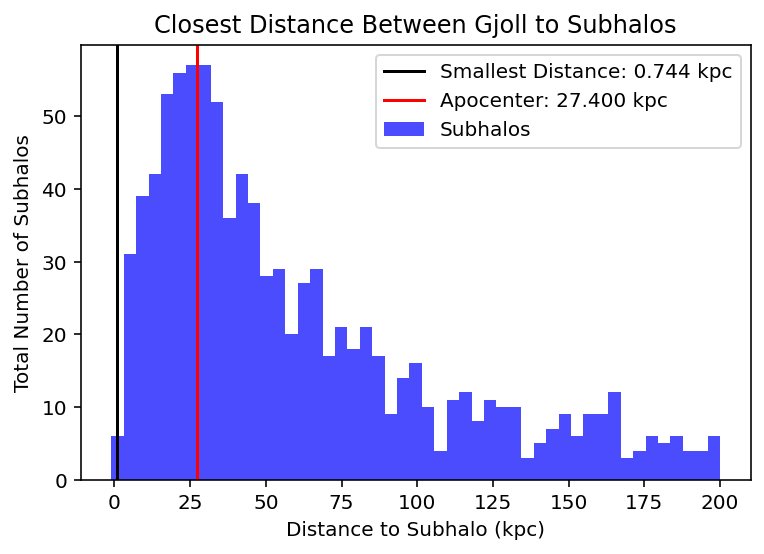

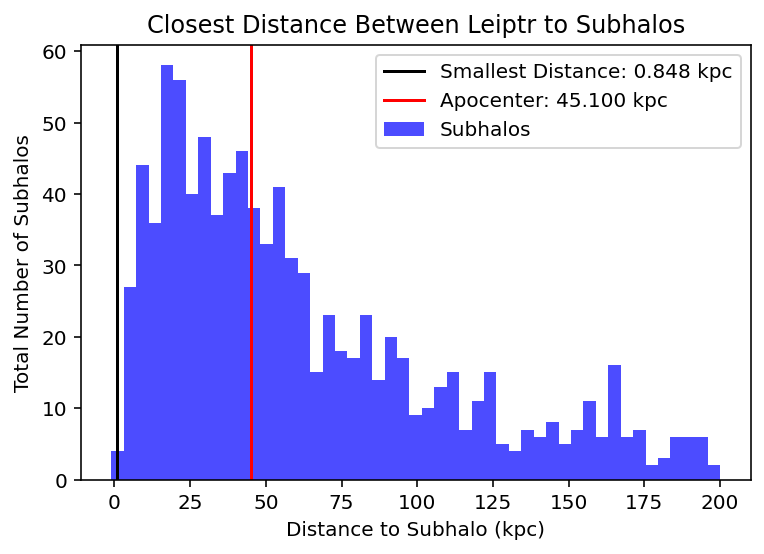

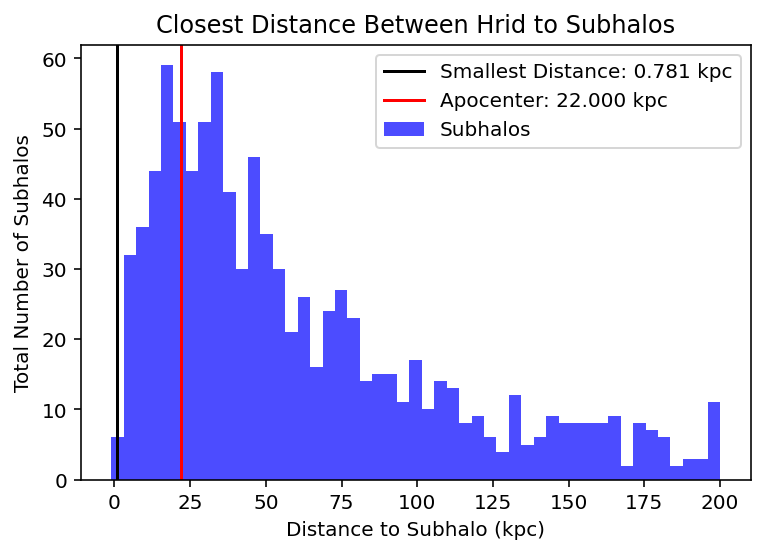

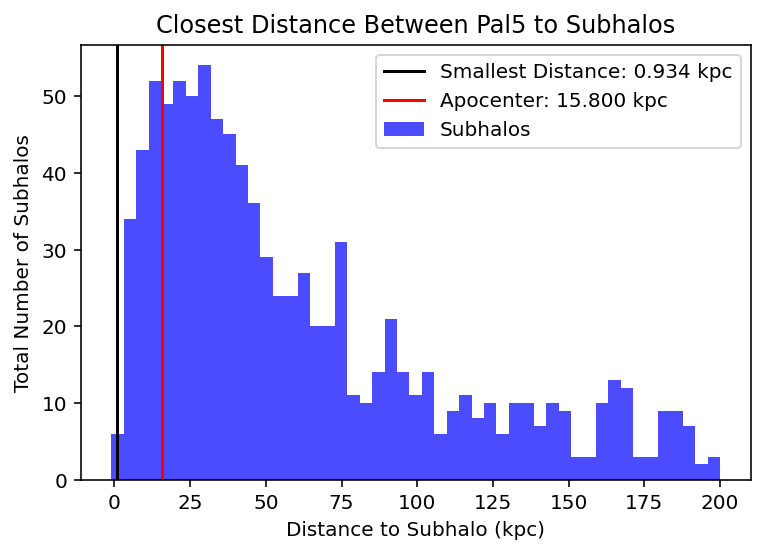

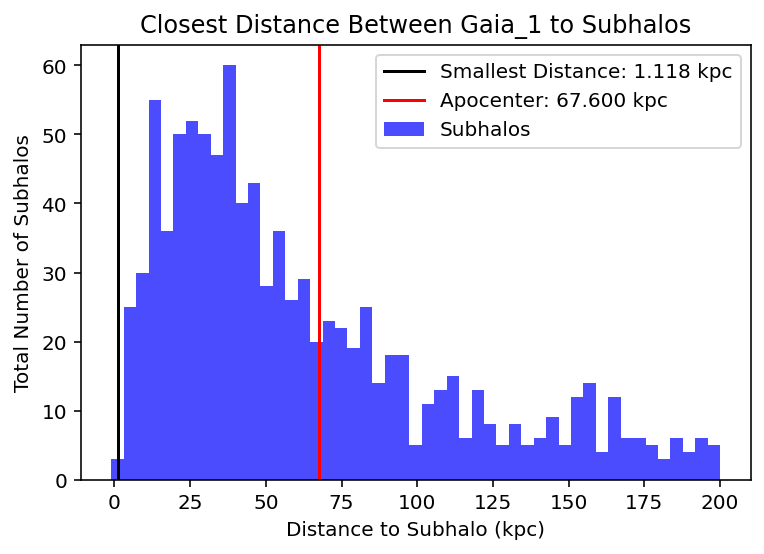

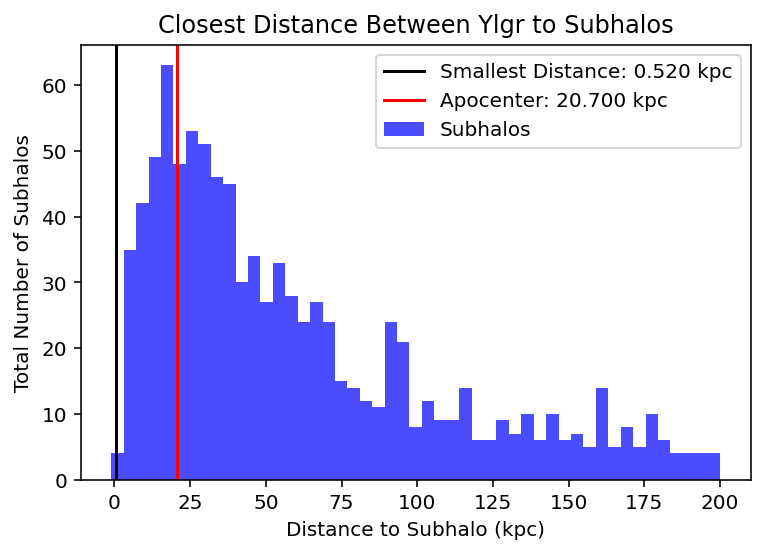

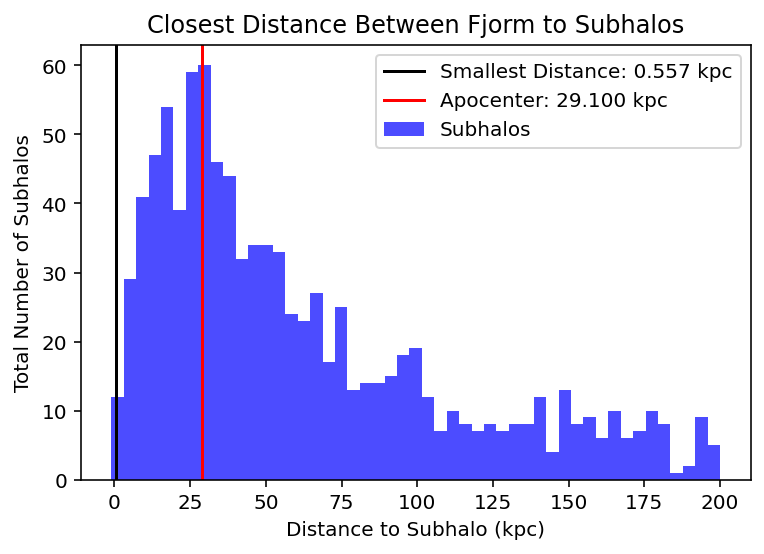

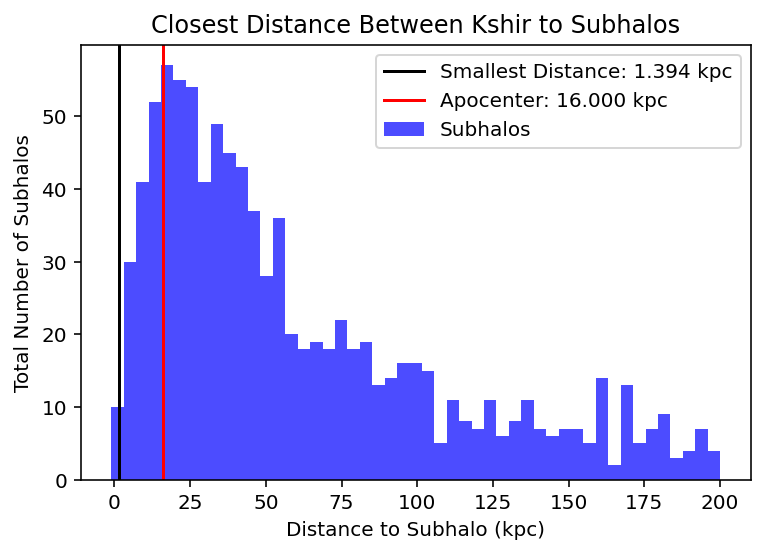

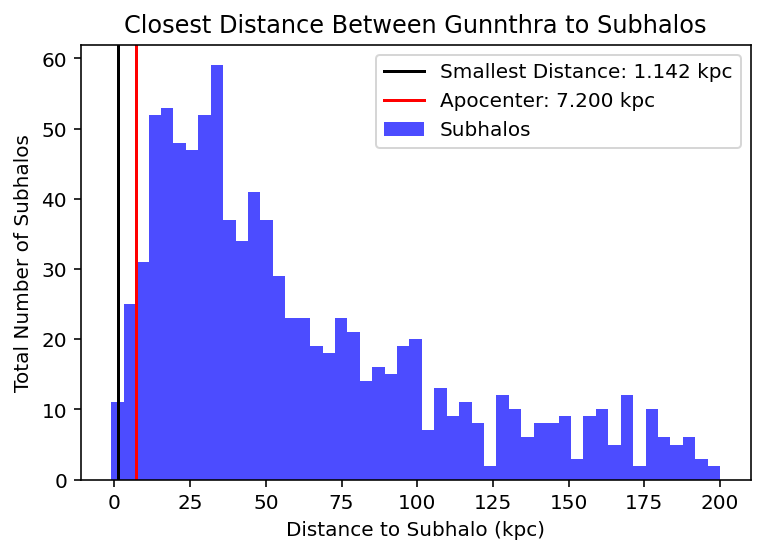

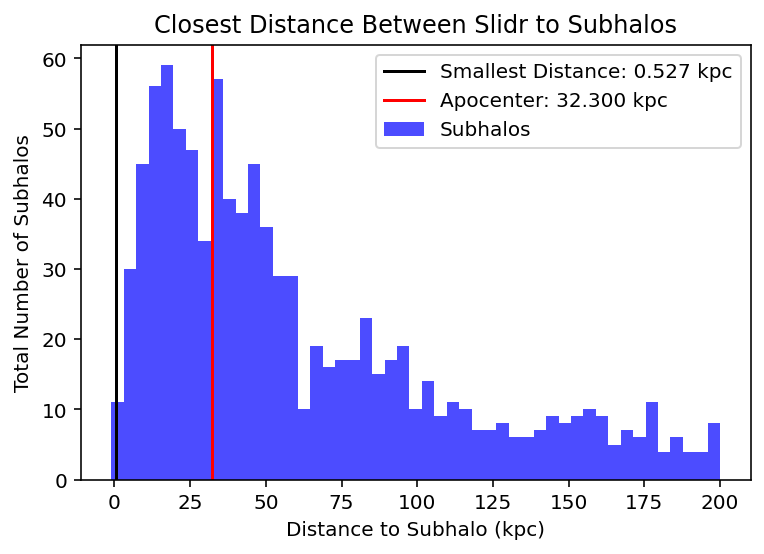

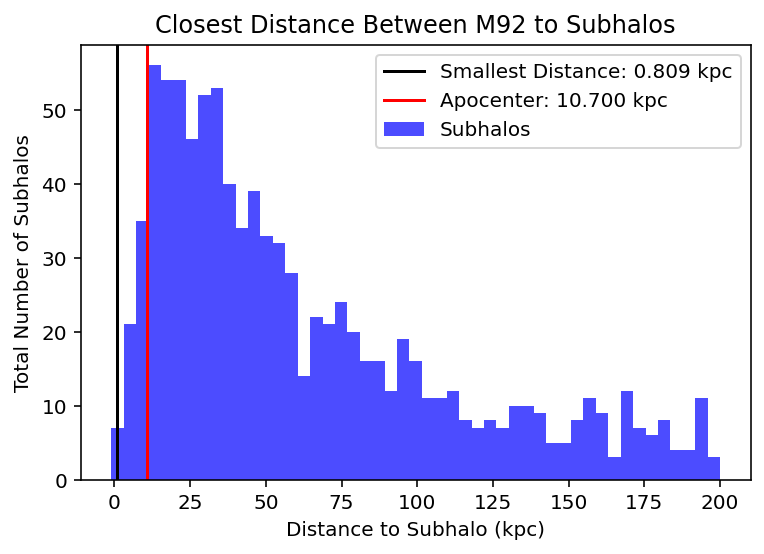

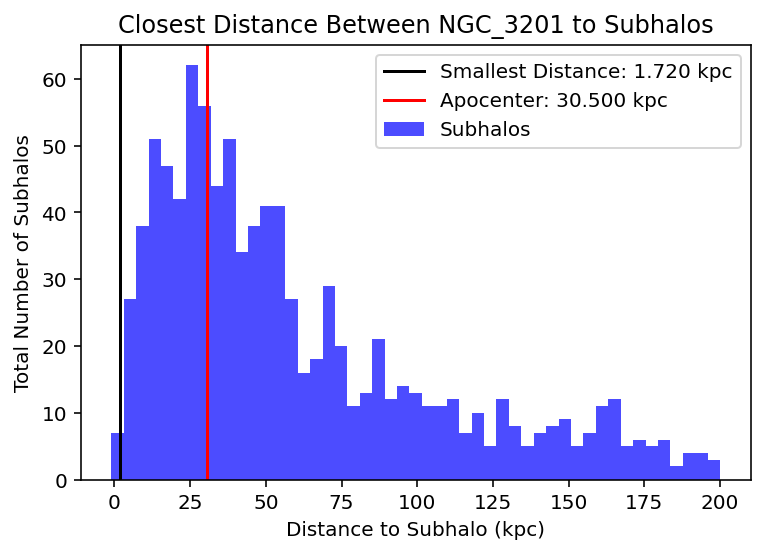

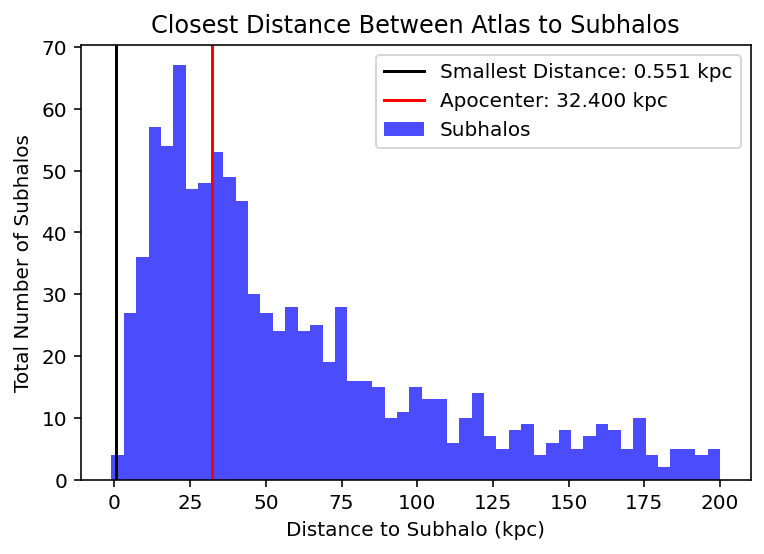

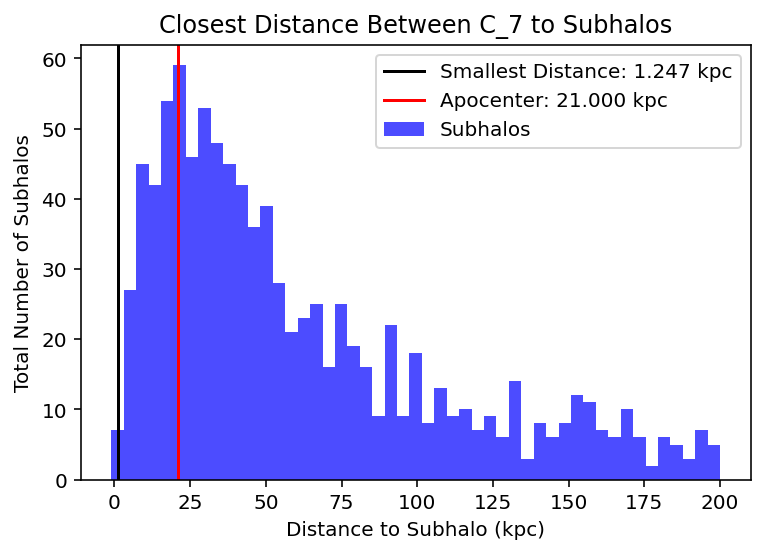

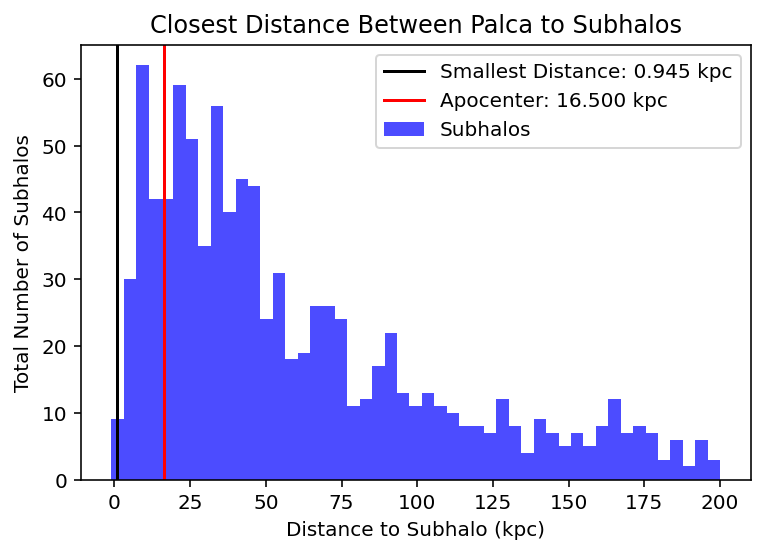

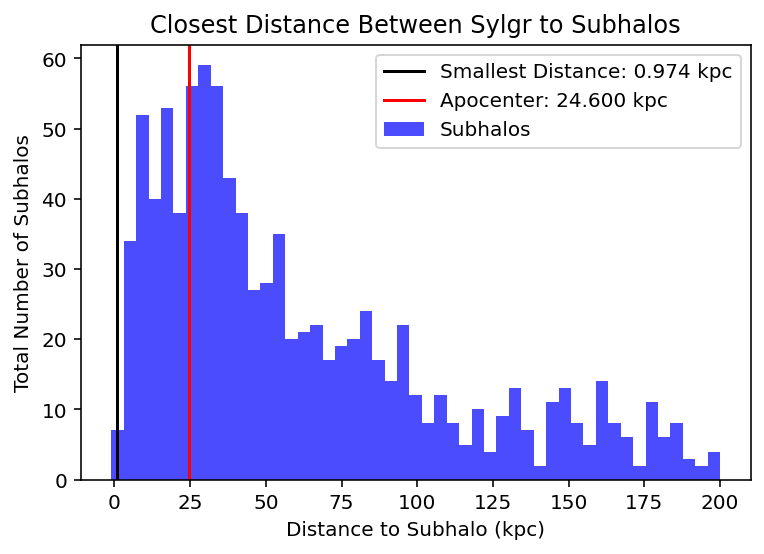

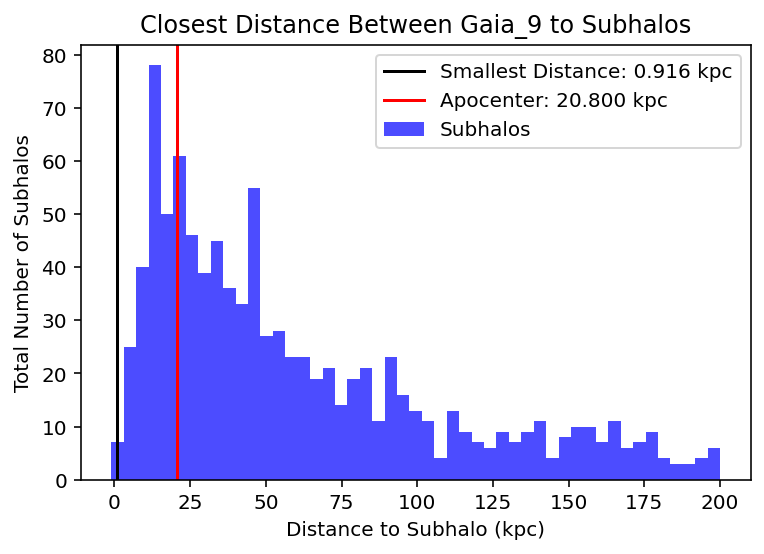

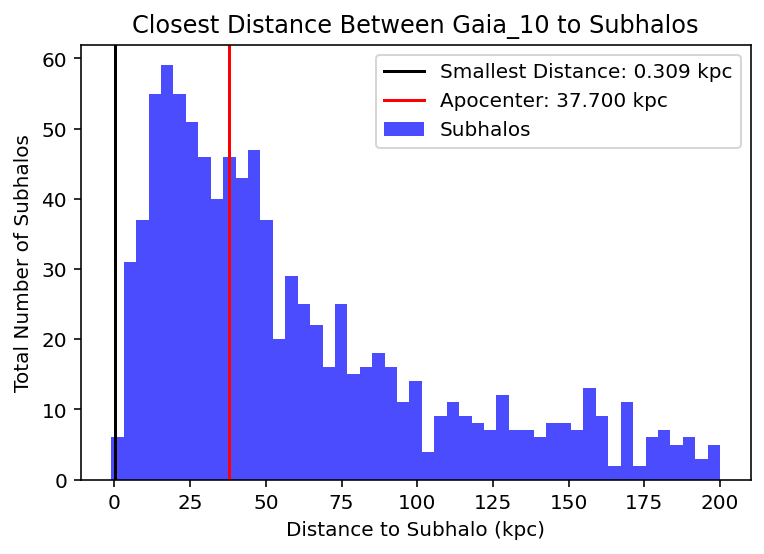

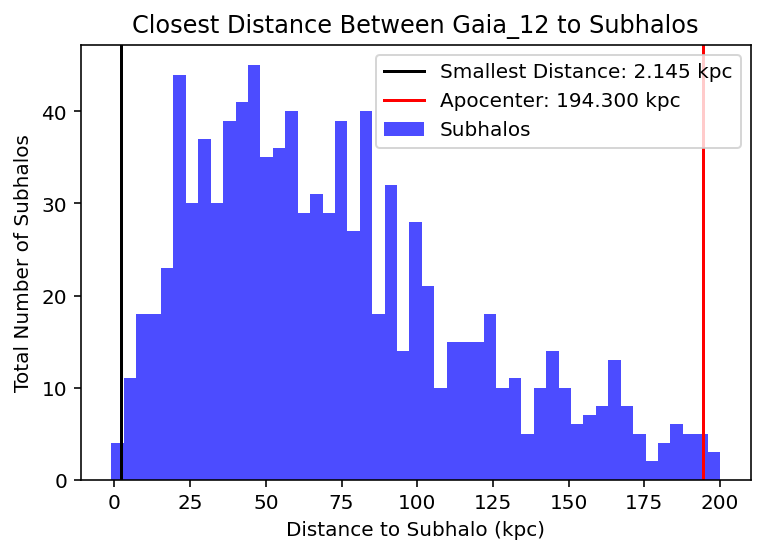

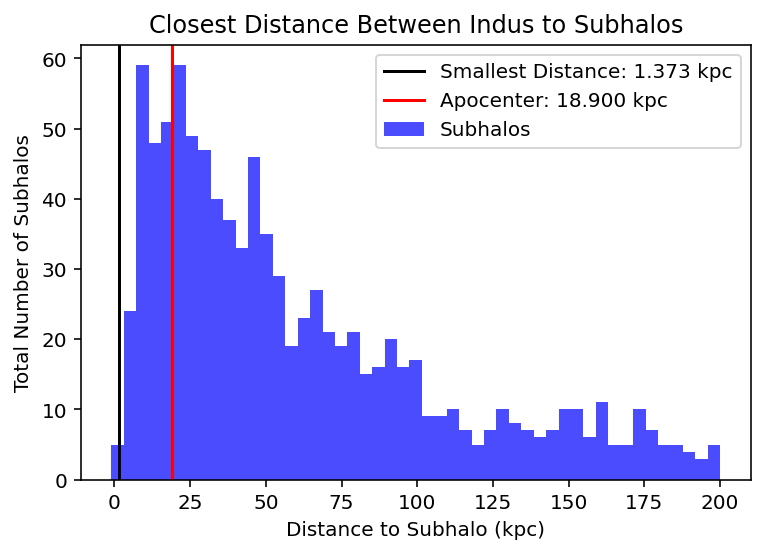

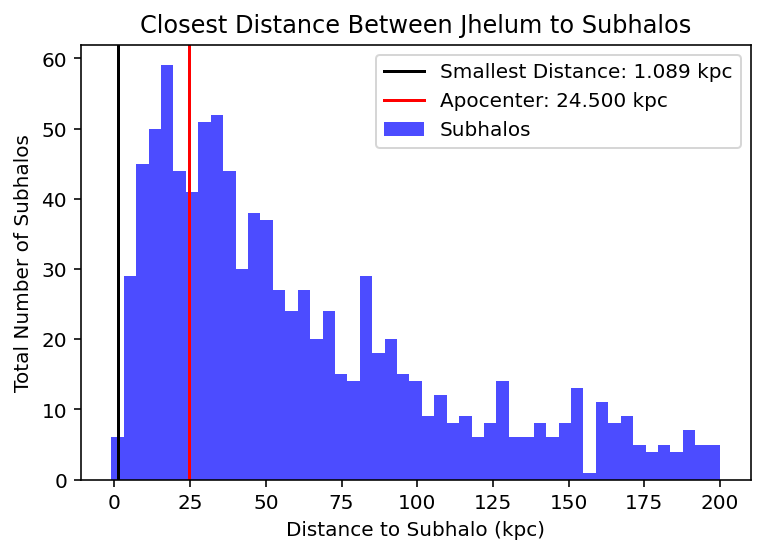

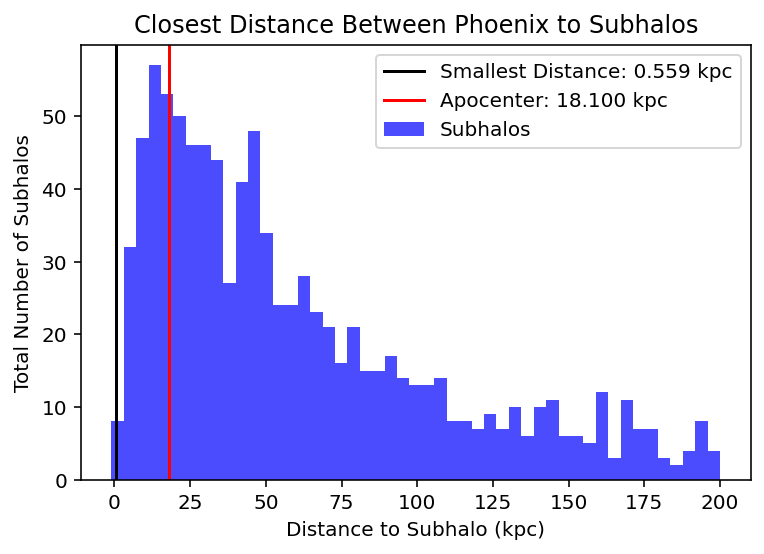

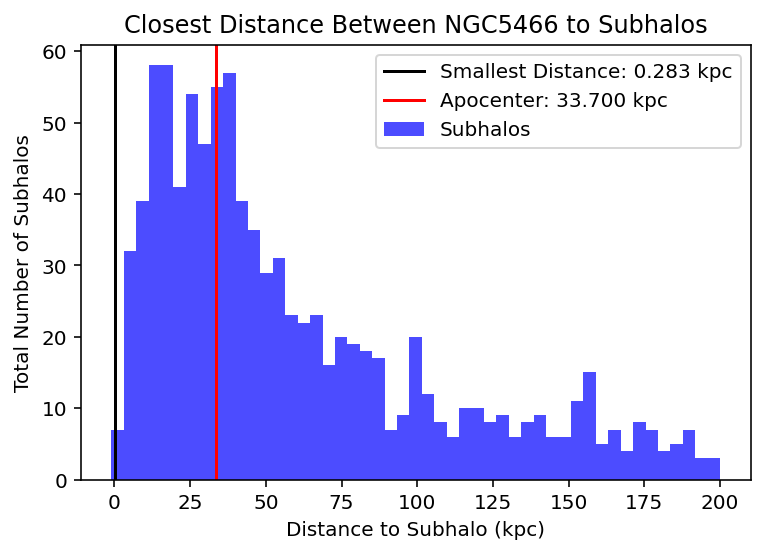

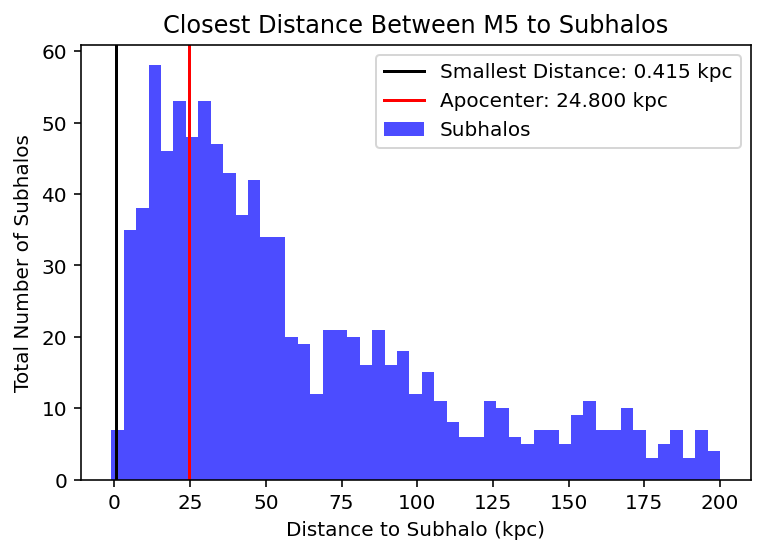

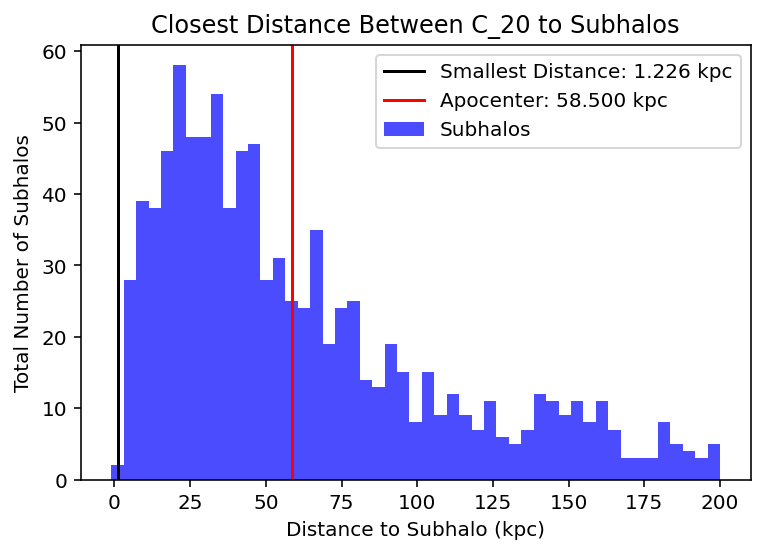

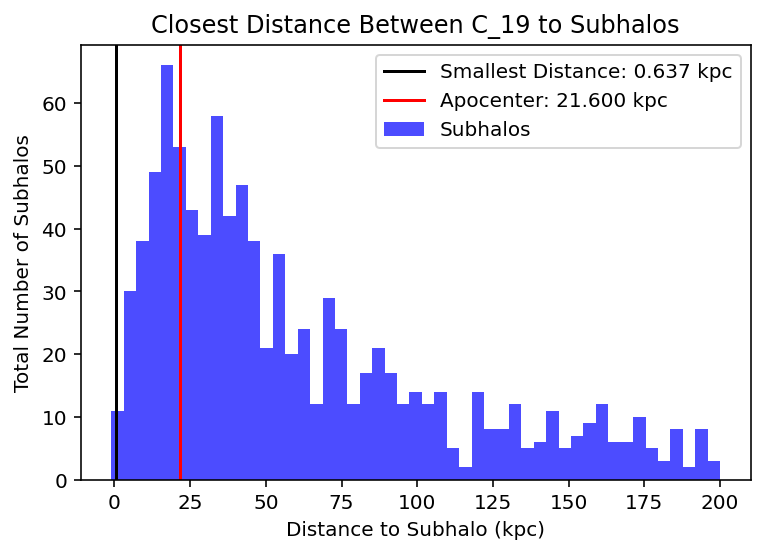

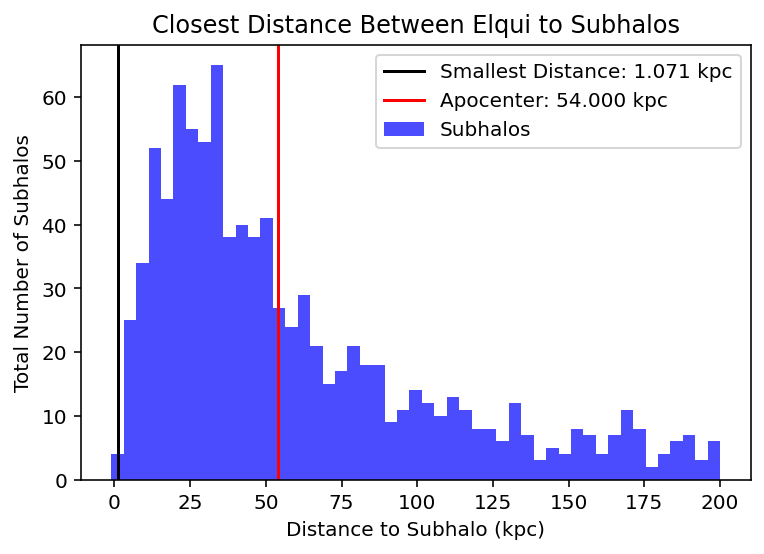

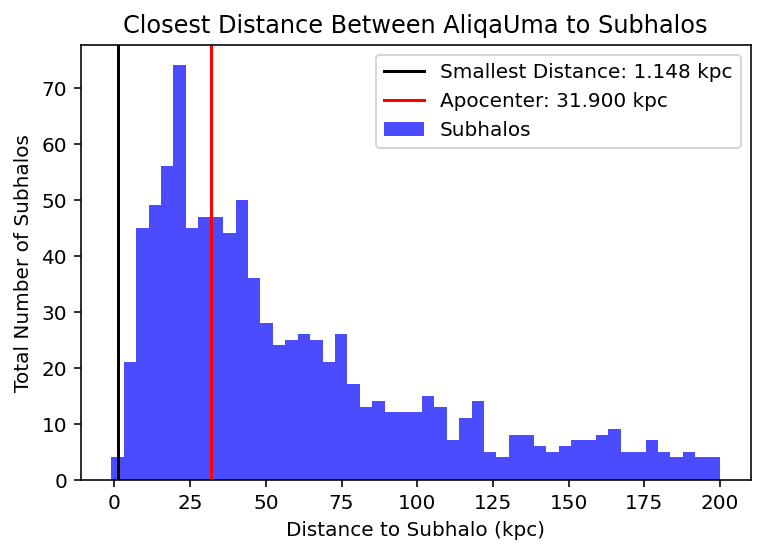

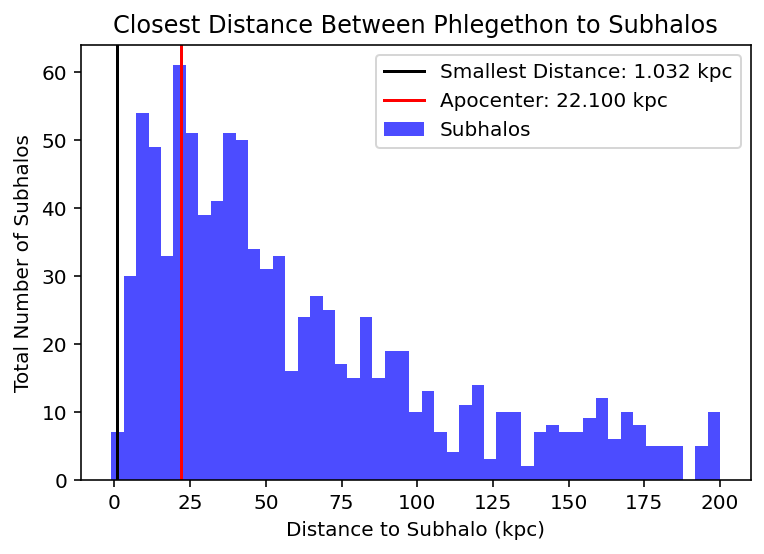

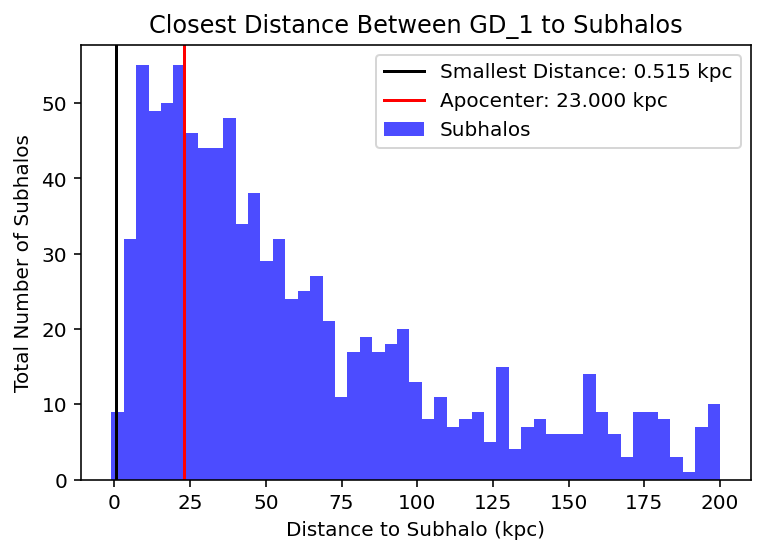

In [44]:
#Creates Histograms for All Streams 
#Include both Apocenter and Pericenter
for i in range(len(pb_new)):
    plt.figure()
    plt.hist(pb_new.iloc[i][1:], bins=np.linspace(-1,200,50), color='blue', alpha=0.7, label='Subhalos');  
    plt.axvline(min(pb_new.iloc[i][1:]), color='black', label = 'Smallest Distance: {:.3f} kpc'.format(min(pb_new.iloc[i][1:])))
    for key in range(len(r_apo.keys())):
        if pb_new.iloc[i][0] == list(r_apo.keys())[key]:
            plt.axvline(r_apo[pb_new.iloc[i][0]], color='red', label = 'Apocenter: {:.3f} kpc'.format(r_apo[pb_new.iloc[i][0]]))
    plt.title('Closest Distance Between {:s} to Subhalos'.format(pb_new.iloc[i][0]))
    plt.xlabel('Distance to Subhalo (kpc)')
    plt.ylabel('Total Number of Subhalos')
    plt.legend(loc='best')
    plt.savefig('Stream_to_Subhalo_Histograms/'+str(pb_new.iloc[i][0])+'.png', transparent=False, dpi=200)
    
    